In [1]:
from netCDF4 import Dataset
from pprint import pprint
from scipy.signal import detrend
import pickle
import xarray as xr
from cartoplot import cartoplot
import itertools
import mask
from scipy.stats import pearsonr
from field_importer import get_field
import pandas as pd
from scipy.interpolate import NearestNDInterpolator
from collections import defaultdict
import scipy.interpolate
from field_importer import get_field
from scipy.stats import linregress
import warnings
from mask import select_region
from select_type import select_type
import numpy.ma as ma
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
from tqdm import trange
from regrid import regrid
import matplotlib.image as mpimg


def rea(my_list):
    
    """Moves the last bit of a list to the front - helps with winter months"""
    
    end = list(my_list)[4:] # Get last four
    beginning = list(my_list)[:4] # Get first three
    result = end+beginning # Put the last four before first three
    return(result)

def remove_infs(x,y):
    
    not_inf_array = ~ np.isinf(y)

    clean_x = np.array(x)[not_inf_array]
    clean_y = np.array(y)[not_inf_array]
    
    return(clean_x,clean_y)

def remove_nans(x,y):

    not_nan_array = ~ np.isnan(y) # Selecte elements of y that are not nan

    clean_x = np.array(x)[not_nan_array] # Select elements of x that correspond to valid y values
    clean_y = np.array(y)[not_nan_array] # Select valid y values
    
    return(clean_x,clean_y)
    

def nanregress(x,y,debug=False):
    
    """Carries out a regression with missing data"""
    
    clean_x, clean_y = remove_nans(x,y)
    
    clean_x, clean_y = remove_infs(clean_x,clean_y)
        
    stats = linregress(clean_x,clean_y) # Regress the valid x-y pairs
    
          
    if debug:
        print()
        print('Nanregress')
        print(list(zip(x,y)))
        print(list(zip(clean_x,clean_y)))
        print(stats)
        print()
    
    return(stats)

def detrender(x,y,debug=False):
    
    """Detrends data by using nanregress"""
    
    stats = nanregress(x,y,debug) # Generate a regression between x and y (pairs with nan values of y are removed)
    
    trend_y = [stats[0]*x_val + stats[1] for x_val in x] # Calculate the straight line value at the x coords
    
    detrended = list(np.subtract(y,trend_y)) # Subtract the straight line values at x coords
    
    return(detrended)

def get_component(dataset,year,month):
    
    
    """Gets the 'thickness' component froms snow or freeboard.
    Dataset keyword must be one of 'SM', 'mW99' or 'free'"""

    data_dir = '/home/robbie/Dropbox/SM_Thickness/data/Components/' # Specify location of thickness component data

    with xr.open_dataset(f'{data_dir}{year}_components.nc') as data: # Open component data for year with xarray

        ds_month = data.where(int(month) == data.month, drop=True) # Select the month of thickness component data

        return(np.array(ds_month[dataset])[0])
    
def denan_based_on_list(*args):
    
    """Takes two lists of corresponding variables and 
    removes pairs where one or both elements are np.nan"""
    
    # Replace these for loops with list comps, then document

    nans_to_pop = []
    for i in range(len(args[0])):
        for series in args:
            if np.isnan(series[i]) or np.isinf(series[i]):
                nans_to_pop.append(i)

    output_list = []

    for series in args:
        for index in sorted(list(dict.fromkeys(nans_to_pop)), reverse=True):
            del series[index]

    return(tuple(args))


/home/robbie/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/robbie/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))


In [2]:
month_list = ["01","02","03","04","10","11","12"]

month_name_list_short = ["Oct","Nov","Dec","Jan", "Feb", "Mar", "Apr"]

month_name_list_full = ["October","November","December","January", "February", "March", "April"]

region_list = [ "Barents",
                "Kara",
                "Laptev",
                "East Siberian",
                "Chukchi",
                "Beaufort",
                "Marginals",
                "Central Arctic"]

full_snow_product_names = {'SM':'SnowModel-LG',
                               'NS':'NESOSIM'}

/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Carry out a month-by-month, year-by-year analysis and output a dataframe

In [3]:
year_range = (2002,2018)

NS_start_year, NS_end_year = 2002, 2015

def analyse():

    results = []
    
    for region, month in itertools.product(region_list, month_list):
        
        print(region,month)

        if region == "Central Arctic":
            yearlist = list(range(2010,year_range[1]+1))
        else:
            yearlist = list(range(year_range[0],year_range[1]+1))

        if int(month) > 7:
            yearlist = yearlist[:-1]
        else:
            yearlist = yearlist[1:]

        for year in yearlist:

            datapoint = {'month':month,
                         'year':year,
                         'region':region}

            with warnings.catch_warnings(): # This avoids incessant mean of empty slice warnings
                warnings.simplefilter("ignore", category=RuntimeWarning)
                
                # Calculate piomas thickness

#                 piomas = get_field('piomas',month=month,year=year,
#                                    resolution=361,variable='thickness')['field']

#                 reg_pio = select_region(region,piomas)

#                 datapoint['pio_thick'] = np.nanmean(reg_pio)


                for dataset in ['SM', 'E5', 'M2', 'NS', 'mW99', 'free']:
                    
                    if (dataset == 'NS') & ~(NS_start_year <= year <= NS_end_year):
                        
                        datapoint[f'FYI {dataset} contribution']   = np.nan
                        datapoint[f'MYI {dataset} contribution']   = np.nan
                        datapoint[f'all {dataset} contribution']   = np.nan
                        datapoint[f'FYI {dataset} thickness']   = np.nan
                        datapoint[f'MYI {dataset} thickness']   = np.nan
                        datapoint[f'all {dataset} thickness']   = np.nan
                        
                    else:
                        
                        contribution = get_component(dataset,year,month)

                        contribution = select_region(region,contribution)

                        FYI_contribution = select_type('fyi', contribution, year, month)
                        MYI_contribution = select_type('myi', contribution, year, month)


                        datapoint[f'FYI {dataset} contribution']   = np.nanmean(FYI_contribution)
                        datapoint[f'MYI {dataset} contribution']   = np.nanmean(MYI_contribution)
                        datapoint[f'all {dataset} contribution']   = np.nanmean(contribution)


                        if dataset != 'free':

                            # Add RF and Snow components to get thickness

                            thickness = contribution + get_component('free',year,month)

                            thickness = select_region(region, thickness)

                            FYI_thickness = select_type('fyi', thickness, year, month)
                            MYI_thickness = select_type('myi', thickness, year, month)

                            datapoint[f'FYI {dataset} thickness']   = np.nanmean(FYI_thickness)
                            datapoint[f'MYI {dataset} thickness']   = np.nanmean(MYI_thickness)
                            datapoint[f'all {dataset} thickness']   = np.nanmean(thickness)


            results.append(datapoint)


            
    
    df = pd.DataFrame(results)
    
    return(df)

# beta = analyse()

# beta.head()

# pickle.dump(beta, open('beta_frame.p','wb'))
beta = pickle.load(open('beta_frame.p','rb'))


seasonal = beta.groupby([beta.region, beta.month]).mean()
seasonal_std = beta.groupby([beta.region, beta.month]).std() 


/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:98: ResourceWarning: unclosed file <_io.BufferedReader name='beta_frame.p'>


In [4]:
print(beta.columns)
beta[beta['year']==2002]

Index(['month', 'year', 'region', 'FYI SM contribution', 'MYI SM contribution',
       'all SM contribution', 'FYI SM thickness', 'MYI SM thickness',
       'all SM thickness', 'FYI E5 contribution', 'MYI E5 contribution',
       'all E5 contribution', 'FYI E5 thickness', 'MYI E5 thickness',
       'all E5 thickness', 'FYI M2 contribution', 'MYI M2 contribution',
       'all M2 contribution', 'FYI M2 thickness', 'MYI M2 thickness',
       'all M2 thickness', 'FYI NS contribution', 'MYI NS contribution',
       'all NS contribution', 'FYI NS thickness', 'MYI NS thickness',
       'all NS thickness', 'FYI mW99 contribution', 'MYI mW99 contribution',
       'all mW99 contribution', 'FYI mW99 thickness', 'MYI mW99 thickness',
       'all mW99 thickness', 'FYI free contribution', 'MYI free contribution',
       'all free contribution'],
      dtype='object')


/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


month  year         region  FYI SM contribution  MYI SM contribution  \
64     10  2002        Barents             0.146594             0.296279   
80     11  2002        Barents             0.273878             0.401796   
96     12  2002        Barents             0.458012             0.452679   
176    10  2002           Kara             0.205748             0.418622   
192    11  2002           Kara             0.518835             0.856974   
208    12  2002           Kara             0.743228             1.058012   
288    10  2002         Laptev             0.147957             0.571296   
304    11  2002         Laptev             0.375128             0.842750   
320    12  2002         Laptev             0.518517             1.008564   
400    10  2002  East Siberian             0.147934             0.460473   
416    11  2002  East Siberian             0.232105             0.597225   
432    12  2002  East Siberian             0.476272             0.719744   
512    10  2002        Chukchi             0.165302             0.597579   
528    11  2002        Chukchi             0.272809             0.790911   
544    12  2002        Chukchi             0.460811             1.004927   
624    10  2002       Beaufort             0.172165             0.543502   
640    11  2002       Beaufort             0.379307             0.769181   
656    12  2002       Beaufort             0.521479             0.922195   
736    10  2002      Marginals             0.165876             0.505307   
752    11  2002      Marginals             0.346304             0.695814   
768    12  2002      Marginals             0.533721             0.813370   

     all SM contribution  FYI SM thickness  MYI SM thickness  \
64              0.155904          0.926917          0.996904   
80              0.292514          1.163126          1.206395   
96              0.456219          1.514768          1.269925   
176             0.251193          1.209425          1.051177   
192             0.568651          1.546355          1.618630   
208             0.804239          1.673709          1.821384   
288             0.258922          0.587913          1.243352   
304             0.447328          0.986305          1.544853   
320             0.593233          1.153546          1.676494   
400             0.323573          0.765020          1.040579   
416             0.401425          0.937455          1.327307   
432             0.607927          1.224542          1.425219   
512             0.305475          0.729171          1.080883   
528             0.408568          0.916691          1.481393   
544             0.570273          1.258591          1.808302   
624             0.323331          0.612362          1.088525   
640             0.527762          1.119313          1.618573   
656             0.663185          1.310471          1.909071   
736             0.290693          0.690223          1.087467   
752             0.450371          1.054941          1.453800   
768             0.623636          1.293835          1.604074   

     all SM thickness  FYI E5 contribution  ...  all NS thickness  \
64           0.932787             0.131750  ...          1.157851   
80           1.171737             0.244641  ...          1.219541   
96           1.389679             0.419916  ...          1.488829   
176          1.102375             0.213168  ...          1.073857   
192          1.569102             0.542554  ...          1.536810   
208          1.723680             0.767310  ...          1.745646   
288          0.795046             0.144096  ...          1.188668   
304          1.080055             0.368699  ...          1.148227   
320          1.234650             0.504400  ...          1.311802   
400          0.953736             0.132672  ...          1.134705   
416          1.137655             0.222792  ...          1.212463   
432          1.339150             0.454330  ...          1.334441   
512          0.853635    

# Plot correlations between RF and snow contributions (for SM and NS)

/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


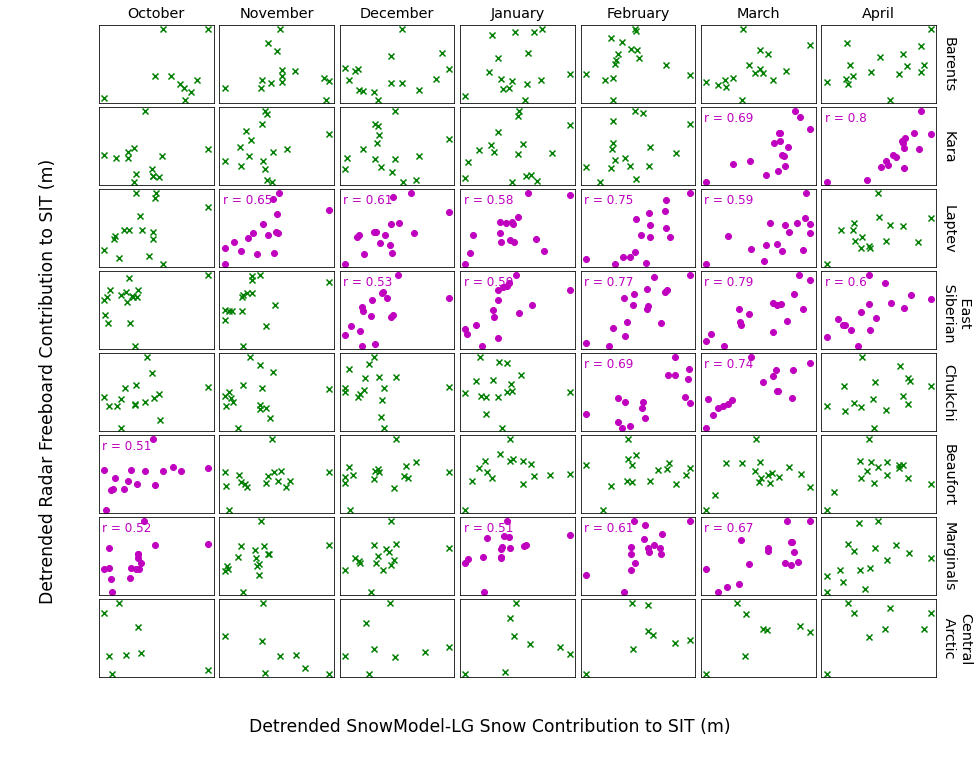

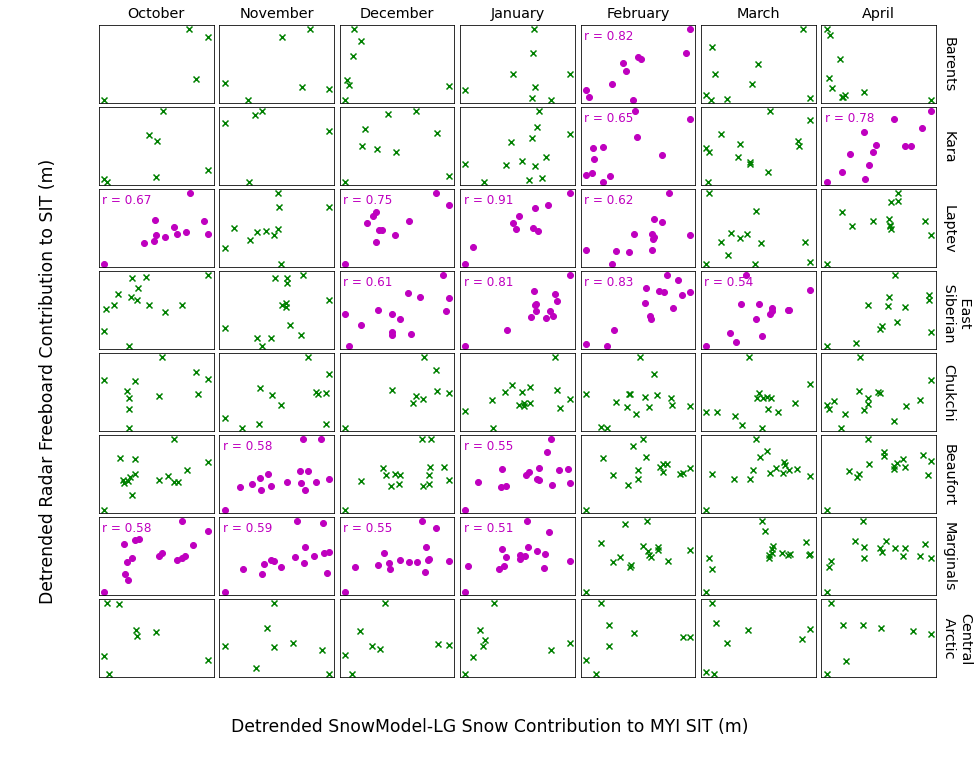

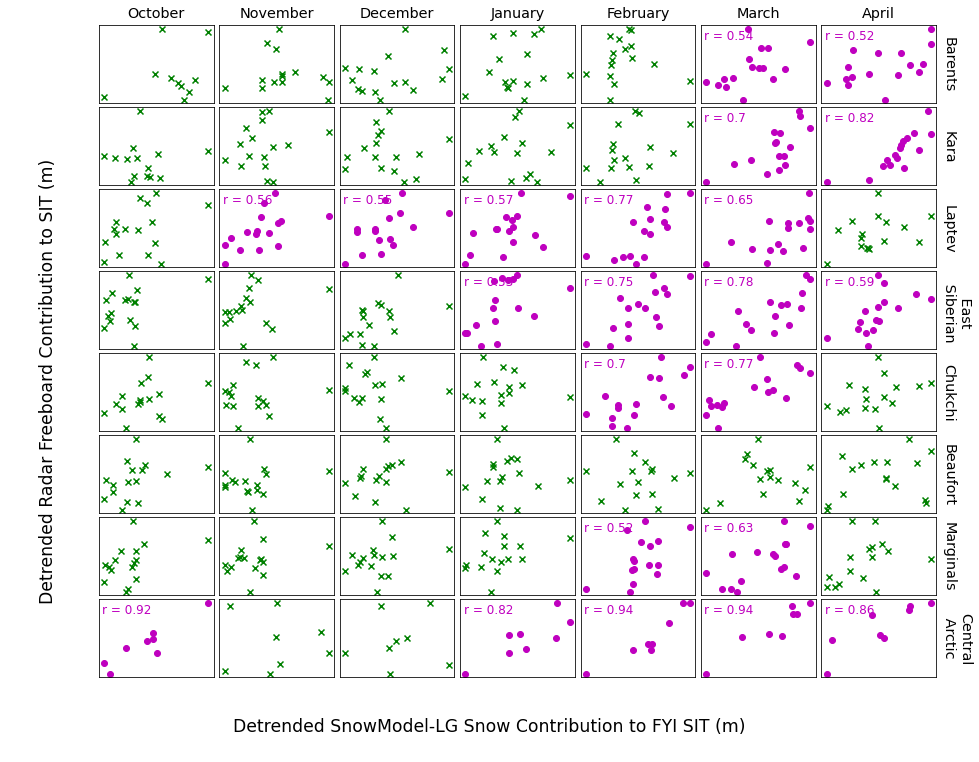

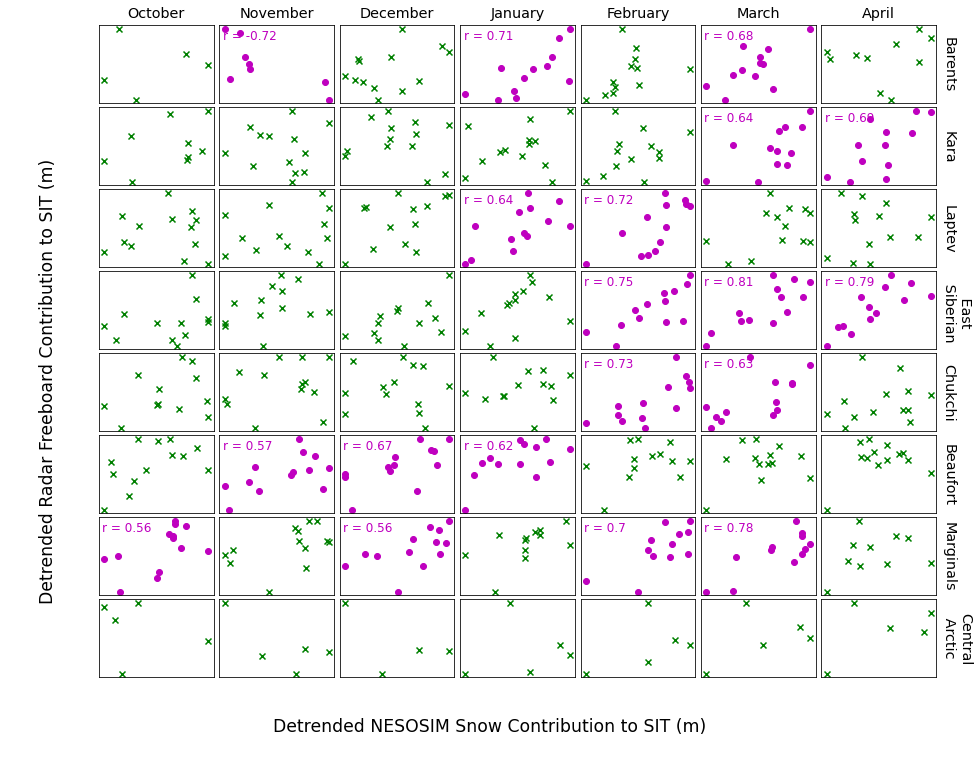

In [5]:
def plot_radar_snow_correlations(ice_type,snow_product):
    
    fig = plt.figure(figsize=(15,12))

    for subplot_counter, (region, month) in enumerate(itertools.product(region_list, rea(month_list)), 1):
        
        d = {}
        
        for var in ['free', snow_product]:
            
            # Subset the main dataframe by month and region

            subset = beta[(beta['month'] == month ) & (beta['region'] == region)]
            
            series = list(subset[f'{ice_type} {var} contribution'])
            
            years  = list(subset['year'])

            detrended_series = detrender(years,series,debug=False)
            
            d[var] = detrended_series
    
        fb, SM = denan_based_on_list(d['free'], d[snow_product])
#         fb, SM = remove_nans(d['free'], d[snow_product])
#         SM, fb = remove_nans(SM, fb)
#         fb, SM = remove_infs(fb, SM)
        
        correlation = pearsonr(fb,SM)


        #######################################################################
        
        ax = plt.subplot(len(region_list),len(month_list),subplot_counter)

        if correlation[1]<0.05:
            markercolor='m'
            marker='o'
            ax.annotate("r = "+str(np.round(correlation[0],decimals=2)),
#                                   + '\np = ' + str(np.round(correlation[1],decimals=2)),
                              xy = (0.03,0.95),xycoords='axes fraction',
                              ha='left',va='top',fontsize="large",color='m')
        else:
            markercolor='g'
            marker='x'

#             if correlation[0] <0:
#                 print(region,month,correlation)

        ax.scatter(fb,SM,
                         marker=marker,label='SM',color=markercolor)

        if subplot_counter < 8:

            ax.annotate(month_name_list_full[subplot_counter-1],
                              xy = (0.5,1.1),xycoords='axes fraction',
                              ha='center',fontsize="x-large")

        if subplot_counter% 7 == 0:
            
            if region == 'Central Arctic':
                region_name = 'Central\n Arctic'
            elif region == 'East Siberian':
                region_name = '    East\n Siberian'
            else:
                region_name = region
            
            ax.annotate(region_name,xy = (1.05,0.5),
                              xycoords='axes fraction',
                              fontsize='x-large',
                              va='center',
                              ha='left',
                              rotation=270)

        ax.set_xticks([])
        ax.set_yticks([])


    plt.annotate("Detrended Radar Freeboard Contribution to SIT (m)",
                 xy = (0.04,0.5),
                 xycoords="figure fraction",
                 rotation=90,
                 fontsize="xx-large",
                 va='center')
    
    ylabcode = {'all':'',
                 'MYI':' MYI',
                 'FYI':' FYI'}

    plt.annotate(f"Detrended {full_snow_product_names[snow_product]} Snow Contribution to{ylabcode[ice_type]} SIT (m)",
                 xy = (0.5,0.04),
                 xycoords="figure fraction",
                 fontsize="xx-large",
                 ha='center')
    
    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    
    dir_to_save = '/home/robbie/Dropbox/Apps/Overleaf/SnowModel-LG_Paper'
    
    if (ice_type == 'all') & (snow_product=='SM'):
        subdir = 'Figures'
    else:
        subdir = 'Sup_Figs'
        
    plt.savefig(f"{dir_to_save}/{subdir}/{full_snow_product_names[snow_product]}_{ice_type}_correlations.png",dpi=450,bbox_inches='tight')

    plt.show()


for ice_type in ['all',
                 'MYI',
                 'FYI',
                ]:
    plot_radar_snow_correlations(ice_type,'SM')
    
plot_radar_snow_correlations('all','NS')

# Process the large dataframe (mbm, yby) into one of trends in each month for each region

In [6]:
def correlate_radar_snow(ice_type,snow_product):

    covariance_data = []

    yticks = [0,0.2,0.4,0.6,0.8,1,1.2]
    
    variables = ['free', snow_product, 'mW99']

    for region, month in itertools.product(region_list, rea(month_list)):
        
        d = {}
        
        for var in variables:
            
            # Subset the main dataframe by month and region

            subset = beta[(beta['month'] == month ) & (beta['region'] == region)]
            
            series = list(subset[f'{ice_type} {var} contribution'])
            
            years  = list(subset['year'])
            
            detrended_series = detrender(years,series)
            
            d[var] = detrended_series

        fb, SM, mw = denan_based_on_list(d['free'], d[snow_product], d['mW99'])

        cov_matrix = np.cov(fb, SM)

        mw_cov_matrix = np.cov(fb,mw)


        results = {'region':region,
                   'month':month,
                   'freeboard_var':cov_matrix[0,0],

                   'snow_var':cov_matrix[1,1],
                   'covariance':cov_matrix[0,1],

                   'mw99_snow_var':mw_cov_matrix[1,1],
                   'mw99_cov_var':mw_cov_matrix[0,1]}

        covariance_data.append(results)
        
    
    df = pd.DataFrame(covariance_data)
    
    df['SIT_var_ind'] = df['freeboard_var'] + df['snow_var'] + df['covariance']
    df['SIT_var'] = df['SIT_var_ind'] + df['covariance']
    df['SIT_std_ind'] = np.sqrt(df['SIT_var_ind'])
    df['SIT_std'] = np.sqrt(df['SIT_var'])
    df['SIT_std_diff'] = df['SIT_std']-df['SIT_std_ind']
    
    return(df)



c = correlate_radar_snow('all', 'SM')
c_NS = correlate_radar_snow('all', 'NS')
c_E5 = correlate_radar_snow('all', 'E5')
c_M2 = correlate_radar_snow('all', 'M2')
# a = correlate_radar_snow('FYI', 'SM')
# b = correlate_radar_snow('MYI', 'SM')



/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


all


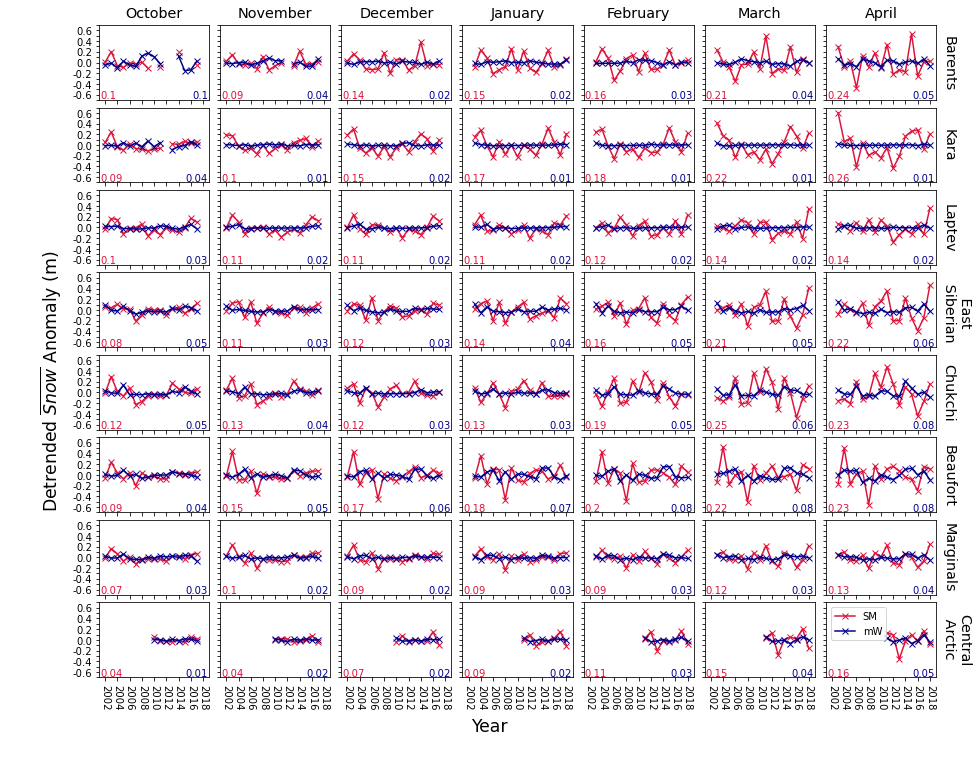

all


/home/robbie/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1541: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe')
/home/robbie/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1541: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe')
/home/robbie/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1541: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe')
/home/robbie/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1541: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe')
/home/robbie/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1541: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe')
/home/robbie/anaconda3/lib/python3.7/site-packages/numpy/lib

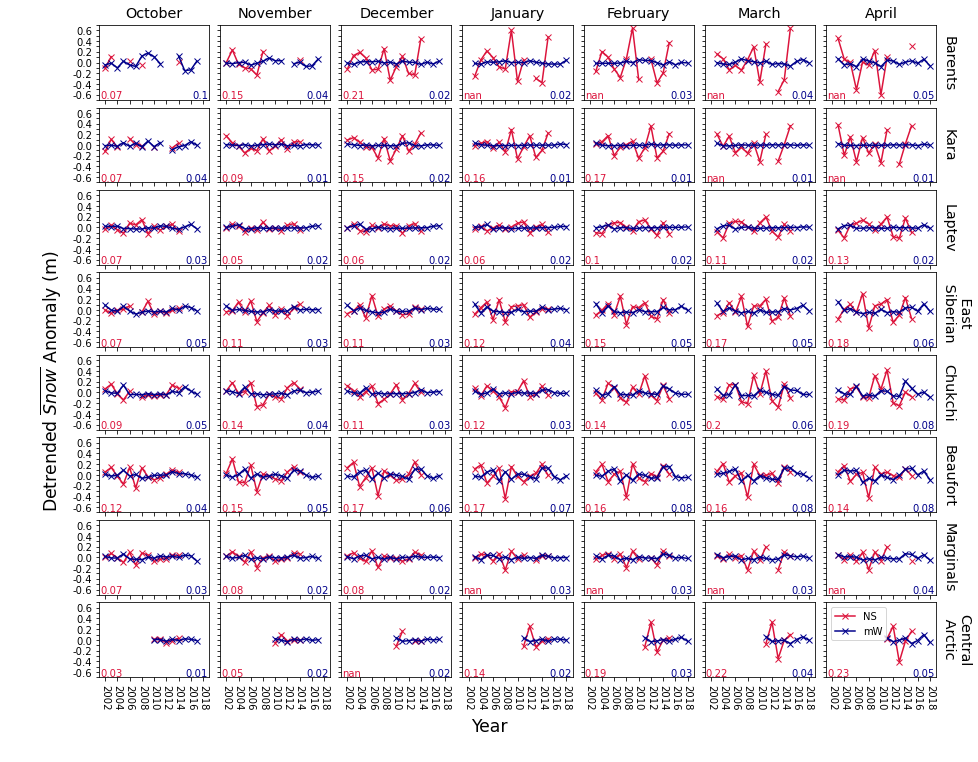

In [7]:
def snow_contribution_timeseries(ice_type,snow_product):
  
    print(ice_type)

    region_annotations = {"Laptev":0.25,
                          "Kara":0.35,
                          "East Siberian":0.05,
                          "Beaufort":0.2,
                          "Central Arctic":0.05,
                          "Chukchi":0.25,
                          "Barents":0}

    fig = plt.figure(figsize=(15,12))
    
    total_subplots = len(region_list)*len(month_list)
    
    for subplot_counter, (region, month) in enumerate(itertools.product(region_list, rea(month_list)), 1):

        ax = plt.subplot(len(region_list),len(month_list),subplot_counter)

        W99_subset = beta[(beta['month'] == month ) & (beta['region'] == region)]
        W99 = list(W99_subset[f'{ice_type} mW99 contribution'])

        SM_subset = beta[(beta['month'] == month ) & (beta['region'] == region)]
        SM = list(SM_subset[f'{ice_type} {snow_product} contribution'])

        yearlist = list(SM_subset['year'])

        ##################################################################

        # Detrend the data

        W99 = detrender(yearlist,W99)
        SM = detrender(yearlist,SM)

        ###################################################################

        # Calculate statistics and color frames

        SM_var = np.round(np.nanstd(SM), decimals=2)
        W99_var = np.round(np.nanstd(W99), decimals=2)


        if region == 'Central Arctic':
        
            SM = np.array(    list(np.full(8,np.nan)) + list(SM)  )
            W99 = np.array(   list(np.full(8,np.nan)) + list(W99) )

            yearlist = np.array(   list(range(2002,2010)) + list(yearlist) )


        ########################################################################

        # Make the line plots
        
        snow_label = 'SM' if snow_product == 'SM' else 'NS'
        
        ax.plot(yearlist,SM,
                      marker='x',label=snow_label,color='crimson')

        ax.plot(yearlist,W99,
                      marker='x',label='mW',color='darkblue')
        
        ax.annotate(SM_var, xy = (0.01,0.02), xycoords = 'axes fraction',color='crimson')
        ax.annotate(W99_var, xy = (0.99,0.02), xycoords = 'axes fraction',color='darkblue', ha='right')

        # Set y axis limits

        scale = 0.7
        ax.set_ylim(-scale,scale)

        # Month name annotations

        if subplot_counter < 8:

            ax.annotate(month_name_list_full[subplot_counter-1],
                              xy = (0.5,1.1),xycoords='axes fraction',
                              fontsize="x-large",ha='center')

        # Region Name Annotations

        if subplot_counter %7 == 0:

            if region == 'Central Arctic':
                region_name = 'Central\n Arctic'
            elif region == 'East Siberian':
                region_name = '    East\n Siberian'
            else:
                region_name = region
            
            ax.annotate(region_name,xy = (1.05,0.5),
                              xycoords='axes fraction',
                              fontsize='x-large',
                              va='center',
                              ha='left',
                              rotation=270)

        # Make y ticks

        yticks = np.linspace(-scale,scale,15)
        yticks = np.around(yticks,decimals=1)
        ylabels = [x if (x*10)%2 == 0 else ""  for x in yticks]


        if (subplot_counter-1) %7 == 0:
            ax.set_yticks(ticks=yticks)
            ax.set_yticklabels(ylabels)
        else:
            ax.set_yticks(ticks=yticks)
            ax.set_yticklabels([])

        # Make x ticks
        ax.set_xlim(2001,2019)
        if subplot_counter <= total_subplots-7:
            ax.set_xticks(ticks=list(range(2002,2019,2)))
            ax.set_xticklabels([])
        else:
            ax.set_xticks(np.arange(2002,2019,2))
            ax.tick_params('x',rotation = 270)

        # Make legend

        if subplot_counter == total_subplots:
            ax.legend(fontsize='medium',loc='upper left')

    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    
    snowbar = r'$\overline{Snow}$'
    
    plt.annotate(f"Detrended {snowbar} Anomaly (m)",
                 xy = (0.04,0.5),
                 xycoords="figure fraction",
                 rotation=90,
                 fontsize="xx-large",
                 va='center')

    plt.annotate("Year",
                 xy = (0.5,0.04),
                 xycoords="figure fraction",
                 fontsize="xx-large",
                 ha='center')

    dir_to_save = '/home/robbie/Dropbox/Apps/Overleaf/SnowModel-LG_Paper'

    if (ice_type == 'all') & (snow_product == 'SM'):
        plt.savefig(f"{dir_to_save}/Figures/{snow_product}_{ice_type}_detrended_variability.png",dpi=400,bbox_inches='tight')
    else:
        plt.savefig(f"{dir_to_save}/Sup_Figs/{snow_product}_{ice_type}_detrended_variability.png",dpi=400,bbox_inches='tight')

    plt.show()
    
    
for ice_type in ['all']:
    snow_contribution_timeseries(ice_type,'SM')
snow_contribution_timeseries('all','NS')

/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


all


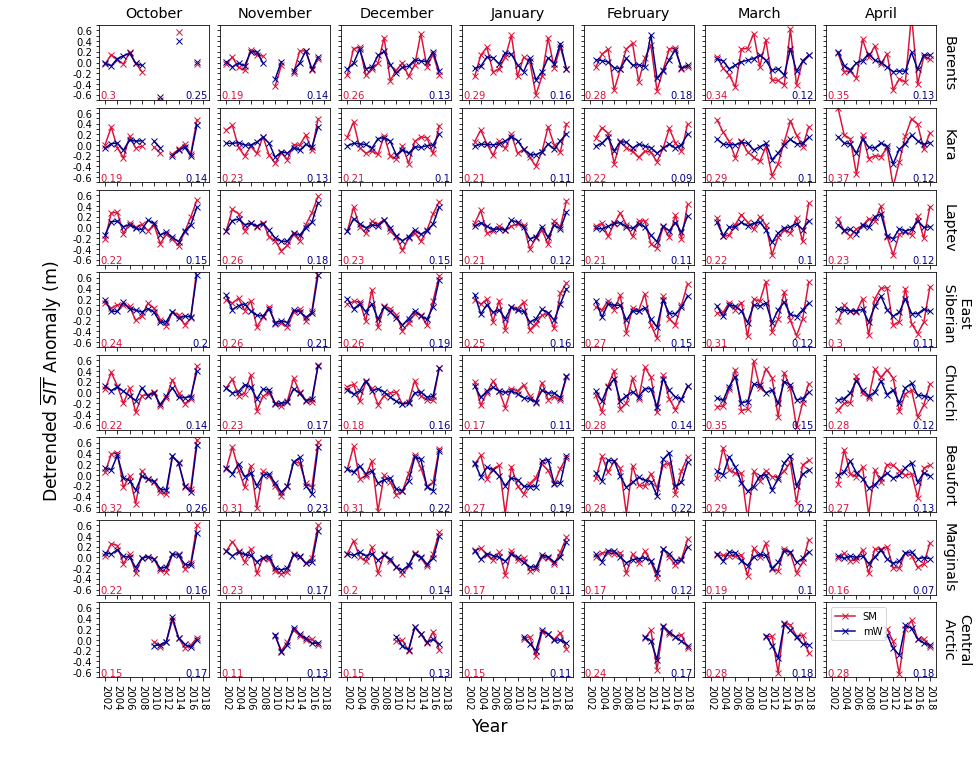

MYI


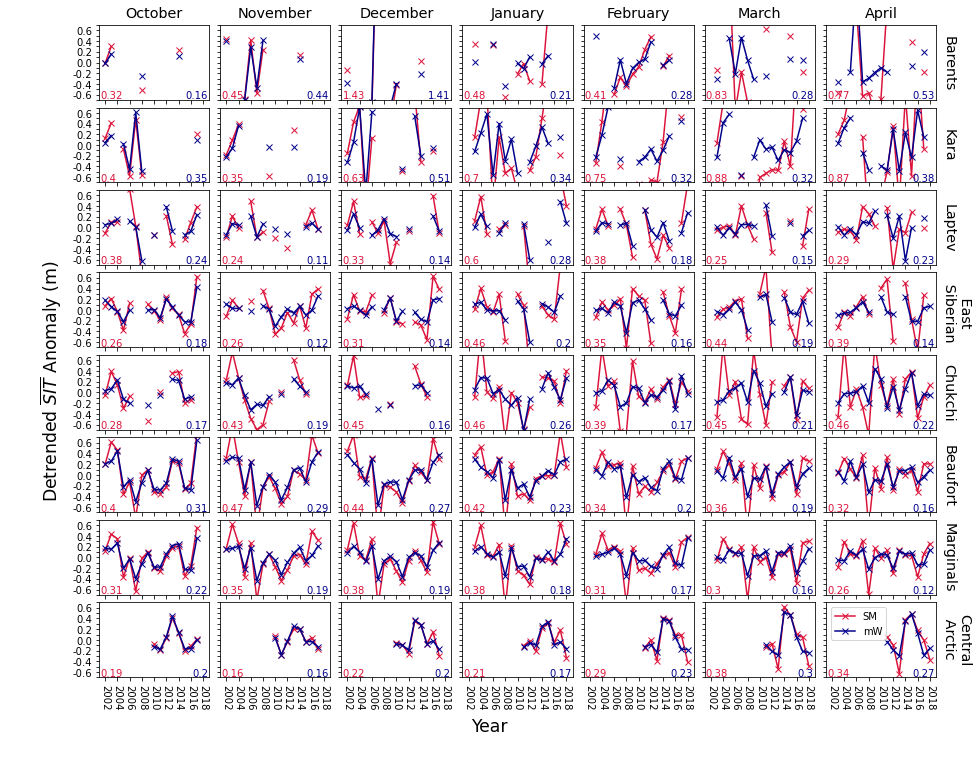

FYI


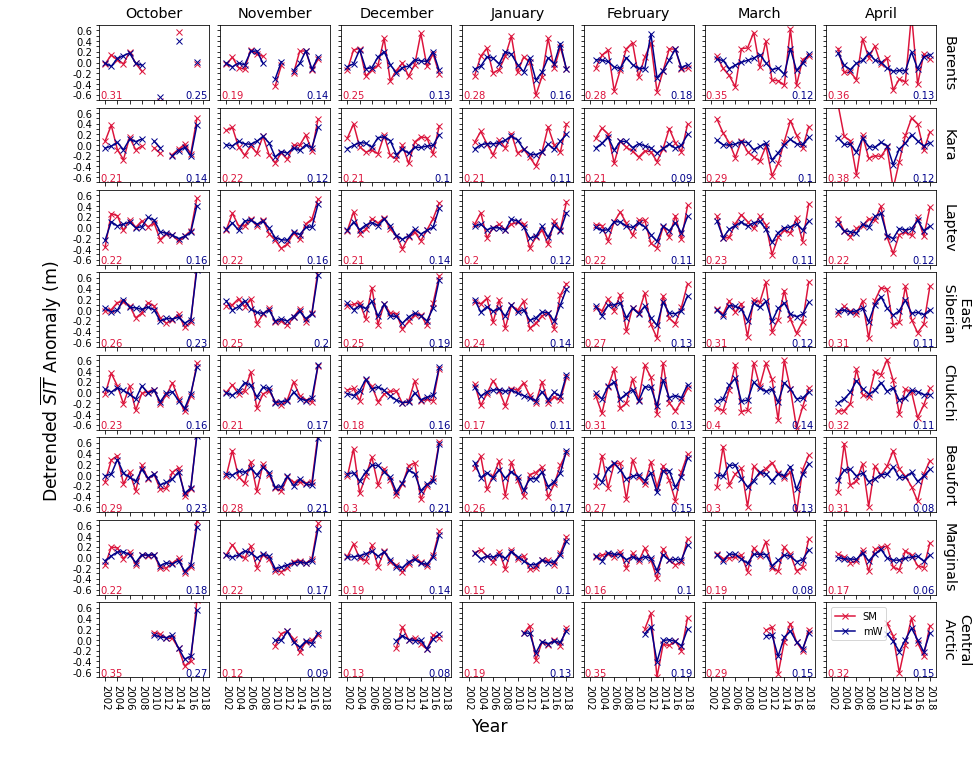

In [10]:
def SIT_contribution_timeseries(ice_type):
  
    print(ice_type)

    region_annotations = {"Laptev":0.25,
                          "Kara":0.35,
                          "East Siberian":0.05,
                          "Beaufort":0.2,
                          "Central Arctic":0.05,
                          "Chukchi":0.25,
                          "Barents":0}

    fig = plt.figure(figsize=(15,12))
    
    total_subplots = len(region_list) * len(month_list)
    
    for subplot_counter, (region, month) in enumerate(itertools.product(region_list, rea(month_list)), 1):

        ax = plt.subplot(len(region_list),len(month_list),subplot_counter)

        W99_subset = beta[(beta['month'] == month ) & (beta['region'] == region)]
        W99 = list(W99_subset[f'{ice_type} mW99 thickness'])

        SM_subset = beta[(beta['month'] == month ) & (beta['region'] == region)]
        SM = list(SM_subset[f'{ice_type} SM thickness'])

        yearlist = list(SM_subset['year'])

        ##################################################################

        # Detrend the data

        W99 = detrender(yearlist,W99)
        SM = detrender(yearlist,SM)

        ###################################################################

        # Calculate statistics and color frames

        SM_var = np.round(np.nanstd(SM), decimals=2)
        W99_var = np.round(np.nanstd(W99), decimals=2)


        if region == 'Central Arctic':
        
            SM = np.array(    list(np.full(8,np.nan)) + list(SM)  )
            W99 = np.array(   list(np.full(8,np.nan)) + list(W99) )

            yearlist = np.array(   list(range(2002,2010)) + list(yearlist) )


        ########################################################################

        # Make the line plots

        ax.plot(yearlist,SM,
                      marker='x',label='SM',color='crimson')

        ax.plot(yearlist,W99,
                      marker='x',label='mW',color='darkblue')
        
        ax.annotate(SM_var, xy = (0.01,0.02), xycoords = 'axes fraction',color='crimson')
        ax.annotate(W99_var, xy = (0.99,0.02), xycoords = 'axes fraction',color='darkblue', ha='right')
    
        # Set y axis limits

        scale = 0.7
        ax.set_ylim(-scale,scale)

        # Month name annotations

        if subplot_counter < 8:

            ax.annotate(month_name_list_full[subplot_counter-1],
                              xy = (0.5,1.1),xycoords='axes fraction',
                              fontsize="x-large",ha='center')

        # Region Name Annotations

        if subplot_counter %7 == 0:

            if region == 'Central Arctic':
                region_name = 'Central\n Arctic'
            elif region == 'East Siberian':
                region_name = '    East\n Siberian'
            else:
                region_name = region
            
            ax.annotate(region_name,xy = (1.05,0.5),
                              xycoords='axes fraction',
                              fontsize='x-large',
                              va='center',
                              ha='left',
                              rotation=270)

        # Make y ticks

        yticks = np.linspace(-scale,scale,15)
        yticks = np.around(yticks,decimals=1)
        ylabels = [x if (x*10)%2 == 0 else ""  for x in yticks]


        if (subplot_counter-1) % 7 == 0:
            ax.set_yticks(ticks=yticks)
            ax.set_yticklabels(ylabels)
        else:
            ax.set_yticks(ticks=yticks)
            ax.set_yticklabels([])

        # Make x ticks
        ax.set_xlim(2001,2019)
        if subplot_counter <= total_subplots-7:
            ax.set_xticks(ticks=list(range(2002,2019,2)))
            ax.set_xticklabels([])
        else:
            ax.set_xticks(np.arange(2002,2019,2))
            ax.tick_params('x',rotation = 270)

        # Make legend


        if subplot_counter == total_subplots:
            ax.legend(fontsize='medium',loc='upper left')

    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.annotate(r"Detrended $\overline{SIT}$ Anomaly (m)",
                 xy = (0.04,0.5),
                 xycoords="figure fraction",
                 rotation=90,
                 fontsize="xx-large",
                 va='center')

    plt.annotate("Year",
                 xy = (0.5,0.04),
                 xycoords="figure fraction",
                 fontsize="xx-large",
                 ha='center')

    dir_to_save = '/home/robbie/Dropbox/Apps/Overleaf/SnowModel-LG_Paper'

    plt.savefig(f"{dir_to_save}/Sup_Figs/{ice_type}_detrended_SIT_variability.png",dpi=450,bbox_inches='tight')

    plt.show()
    
    
for ice_type in ['all','MYI', 'FYI']:
    SIT_contribution_timeseries(ice_type)
# SIT_contribution_timeseries('all','NS')

/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


all


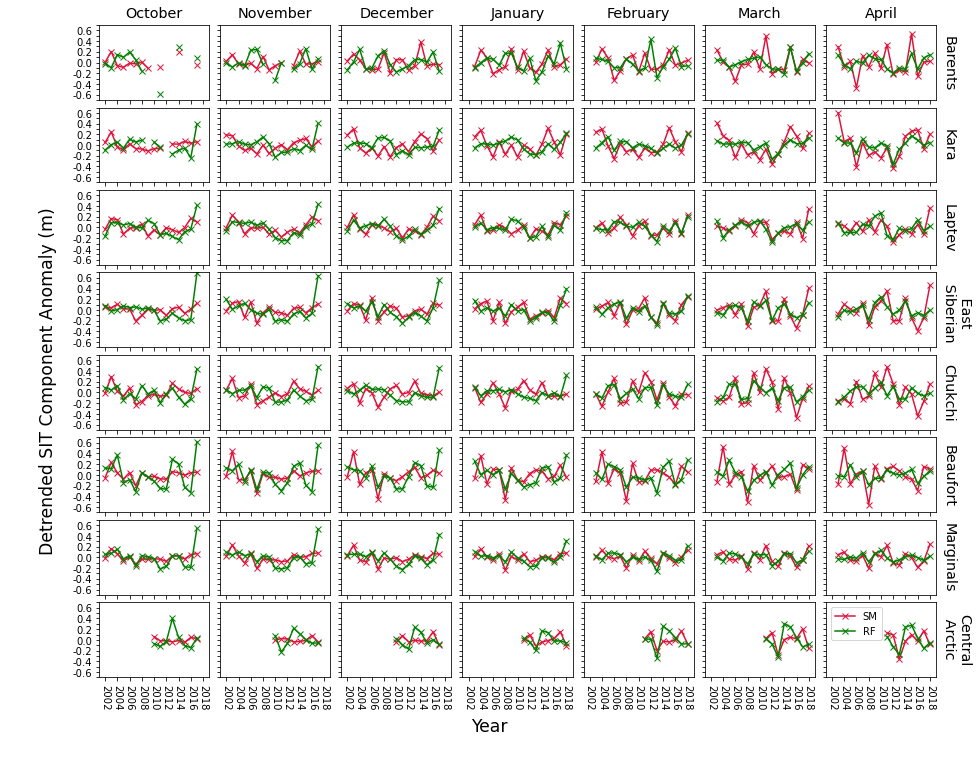

In [11]:
def snow_contribution_timeseries(ice_type):
    
    print(ice_type)

    region_annotations = {"Laptev":0.25,
                          "Kara":0.35,
                          "East Siberian":0.05,
                          "Beaufort":0.2,
                          "Central Arctic":0.05,
                          "Chukchi":0.25,
                          "Barents":0}

    fig = plt.figure(figsize=(15,12))

    total_subplots = len(region_list) * len(month_list)
    
    for subplot_counter, (region, month) in enumerate(itertools.product(region_list, rea(month_list)), 1):

        ax = plt.subplot(len(region_list),len(month_list),subplot_counter)

        W99_subset = beta[(beta['month'] == month ) & (beta['region'] == region)]
        W99 = list(W99_subset[f'{ice_type} free contribution'])

        SM_subset = beta[(beta['month'] == month ) & (beta['region'] == region)]
        SM = list(SM_subset[f'{ice_type} SM contribution'])

        yearlist = list(SM_subset['year'])

        ##################################################################

        # Detrend the data

        W99 = detrender(yearlist,W99)
        SM = detrender(yearlist,SM)

        ###################################################################

        # Calculate statistics and color frames

        SM_var = np.nanstd(SM)
        W99_var = np.nanstd(W99)

        if region == "Central Arctic":
            SM = np.array(    list(np.full(8,np.nan)) + list(SM)  )
            W99 = np.array(   list(np.full(8,np.nan)) + list(W99) )

            yearlist = np.array(   list(range(2002,2010)) + list(yearlist) )

        ########################################################################

        # Make the line plots

        ax.plot(yearlist,SM,
                      marker='x',label='SM',color='crimson')

        ax.plot(yearlist,W99,
                      marker='x',label='RF',color='green')


#             ax = plt.annotate(r'$\sigma(SM) = ' + str(SM_var) + r'$\sigma(mW99) = ' + str(W99_var),
#                               fontsize='large',
#                               xy = (0.03,0.03),
#                               xycoords='axes fraction',
#                               ha='left',color='k')

        # Set y axis limits

        scale = 0.7
        ax.set_ylim(-scale,scale)

#             if region in ["Central Arctic", "Kara"]:
#                 ax = plt.ylim(0,2)
#             elif region in ["Barents","Beaufort", "East Siberian", "Laptev"]:
#                 plt.ylim(0,1.6)

        # Month name annotations

        if subplot_counter <= len(month_list):

            ax.annotate(month_name_list_full[subplot_counter-1],
                              xy = (0.5,1.1),xycoords='axes fraction',
                              fontsize="x-large",ha='center')

        # Region Name Annotations


        if subplot_counter% 7 == 0:
            
            if region == 'Central Arctic':
                region_name = 'Central\n Arctic'
            elif region == 'East Siberian':
                region_name = '    East\n Siberian'
            else:
                region_name = region
            
            ax.annotate(region_name,xy = (1.05,0.5),
                              xycoords='axes fraction',
                              fontsize='x-large',
                              va='center',
                              ha='left',
                              rotation=270)
        # Make y ticks

        yticks = np.linspace(-scale,scale,15)
        yticks = np.around(yticks,decimals=1)
        ylabels = [x if (x*10)%2 == 0 else ""  for x in yticks]


#             if region in ["Central Arctic",  "Kara"]:
#                 yticks = np.linspace(0,1.8,7)
#                 yticks = np.around(yticks,decimals=2)
#             else:
#                 yticks = np.linspace(0,1.4,8)
#                 yticks = np.around(yticks,decimals=2)

        if (subplot_counter-1) % 7 == 0:
            ax.set_yticks(yticks)
            ax.set_yticklabels(ylabels)
        else:
            ax.set_yticks(yticks)
            ax.set_yticklabels([])

        # Make x ticks
        ax.set_xlim(2001,2019)
        if subplot_counter <= total_subplots-7:
            ax.set_xticks(ticks=list(range(2002,2019,2)))
            ax.set_xticklabels([])
        else:
            ax.set_xticks(np.arange(2002,2019,2))
            ax.tick_params('x',rotation = 270)

        # Make legend

        if subplot_counter == total_subplots:
            ax.legend(fontsize='medium',loc='upper left')

    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.annotate(r"Detrended SIT Component Anomaly (m)",
                 xy = (0.04,0.5),
                 xycoords="figure fraction",
                 rotation=90,
                 fontsize="xx-large",
                 va='center')

    plt.annotate("Year",
                 xy = (0.5,0.04),
                 xycoords="figure fraction",
                 fontsize="xx-large",
                 ha='center')
    
    dir_to_save = '/home/robbie/Dropbox/Apps/Overleaf/SnowModel-LG_Paper'

    
    if ice_type == 'all':
        sub_dir = 'Figures'
    else:
        sub_dir = 'Sup_Figs'
        
    plt.savefig(f"{dir_to_save}/{sub_dir}/{ice_type}_RF_SNOW_variability.png",dpi=500,bbox_inches='tight')

    plt.show()

a = snow_contribution_timeseries('all')
# b = snow_contribution_timeseries('FYI')
# c = snow_contribution_timeseries('MYI')

# Contributions to total IAV

/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


SnowModel-LG:


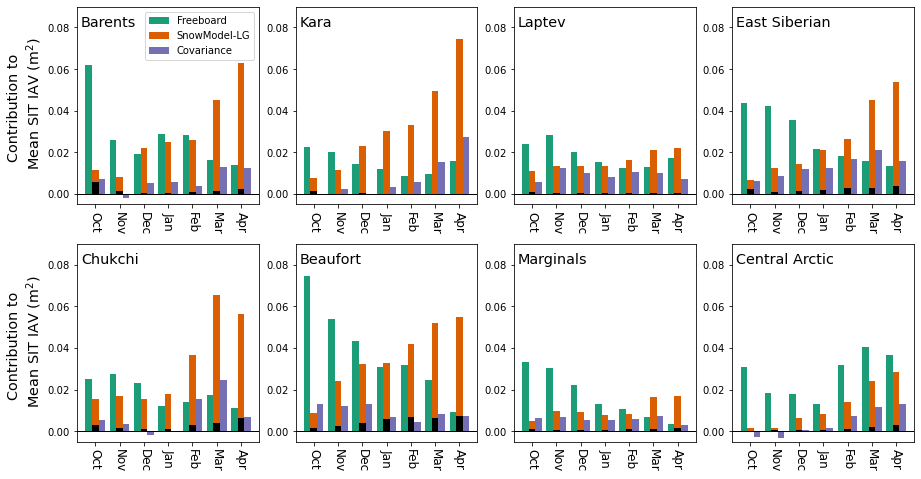

Nesosim:


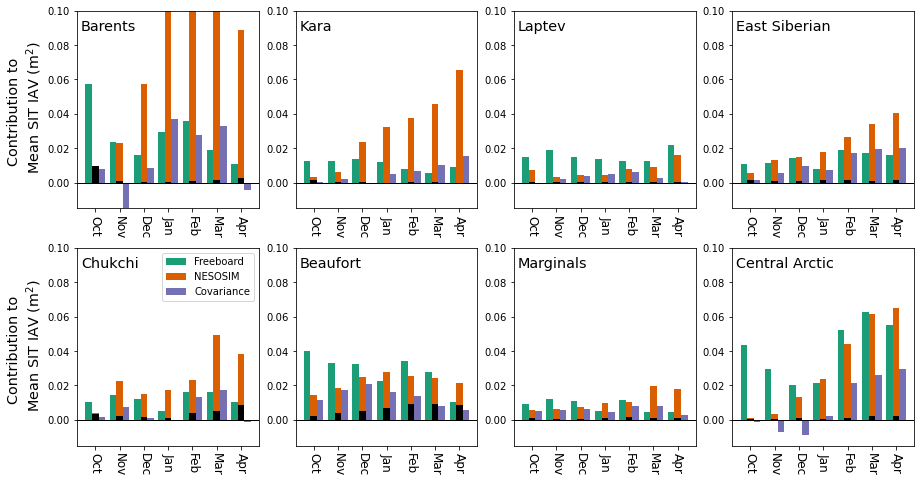

In [12]:
def abs_var_bar(c,snow_code):

    fig = plt.figure(figsize=(15,8))

    for subplot_counter, region in enumerate(region_list, 1):

        subset = c[c['region'] == region]

        fb_var = subset['freeboard_var']
        sm_var = subset['snow_var']
        covar = subset['covariance']

        mw_var = subset['mw99_snow_var']
        mw_covar = subset['mw99_cov_var']


        x = np.array(range(len(fb_var)))

        ax = plt.subplot(2,4,subplot_counter)

        bw = 0.27

        ax.bar(x-bw, fb_var, width=bw, color='#1b9e77', align='center',label='Freeboard')
        ax.bar(x, sm_var, width=bw, color='#d95f02', align='center',label=f'{full_snow_product_names[snow_code]}')
        ax.bar(x, mw_var, width=bw, fc='k', align='center') 
        ax.bar(x+bw, covar, width=bw, color = '#7570b3', align = 'center', label = 'Covariance')
        ax.set_xticks([0,1,2,3,4,5,6])
        ax.set_xticklabels(month_name_list_short,
                        fontsize='large',rotation=270)
        
        legend_box = 1 if snow_code == 'SM' else 5
        if subplot_counter == legend_box: ax.legend(fontsize='medium',loc='upper right')

        ax.annotate(region,xy = (0.02,0.9),xycoords='axes fraction',fontsize='x-large')
        ax.axhline(y=0, color='k', linewidth = 1)
        
        if snow_code == 'SM':
            ax.set_ylim(-0.005,0.09)
        elif snow_code == 'NS':
            ax.set_ylim(-0.015,0.1)

        if subplot_counter in [1,5]:
            ax.set_ylabel('Contribution to \n Mean SIT IAV (m$^2$)', fontsize = 'x-large')


    #     if subplot_counter > 4:
    #         ax.set_xlabel('Month', fontsize = 'x-large')

    
    
    sub_dir = 'Figures' if snow_code == 'SM' else 'Sup_Figs'
    dir_to_save = f'/home/robbie/Dropbox/Apps/Overleaf/SnowModel-LG_Paper/{sub_dir}'
    fig.savefig(f'{dir_to_save}/abs_var_breakdown_{snow_code}.png',
                dpi=450, bbox_inches='tight')

    plt.show()

print('SnowModel-LG:')
abs_var_bar(c,'SM')
print('Nesosim:')
abs_var_bar(c_NS,'NS')

/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a 

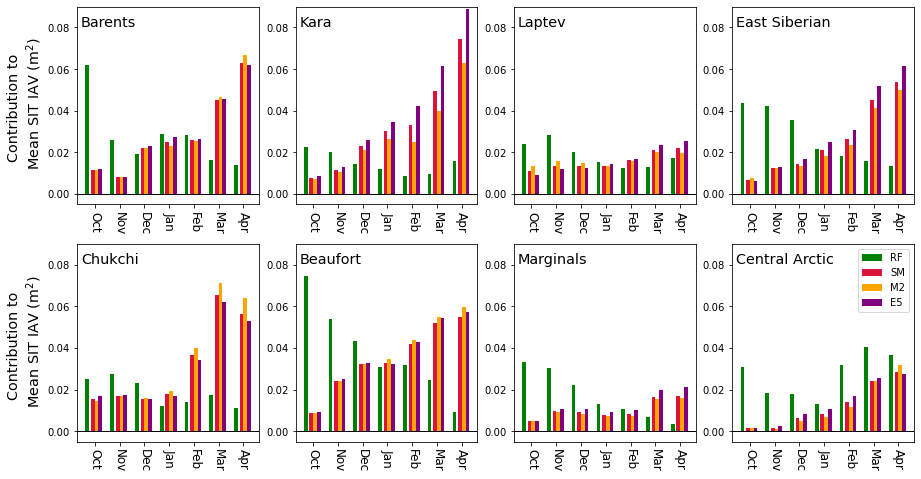

In [34]:
keys = ['M2','E5','SM']

def compare_reanalyses(list_of_frames,dict_of_codes):

    fig = plt.figure(figsize=(15,8))
    
    bw = 0.15
    
    for c, snow_code in zip(list_of_frames, dict_of_codes.keys()):

        for subplot_counter, region in enumerate(region_list, 1):

            subset = c[c['region'] == region]

            fb_var = subset['freeboard_var']
            sm_var = subset['snow_var']

            x = np.array(range(len(fb_var)))

            ax = plt.subplot(2,4,subplot_counter)
            
            if snow_code == 'SM':
                ax.bar(x-(2*bw), fb_var, width=bw, color='green', align='center',label='RF')
                

                ax.set_xticks([0,1,2,3,4,5,6])
                ax.set_xticklabels(month_name_list_short,
                                fontsize='large',rotation=270)


                ax.annotate(region,xy = (0.02,0.9),xycoords='axes fraction',fontsize='x-large')
                ax.axhline(y=0, color='k', linewidth = 1)

                if snow_code == 'SM':
                    ax.set_ylim(-0.005,0.09)
                elif snow_code == 'NS':
                    ax.set_ylim(-0.015,0.1)

                if subplot_counter in [1,5]:
                    ax.set_ylabel('Contribution to \n Mean SIT IAV (m$^2$)', fontsize = 'x-large')
                
            ax.bar(x+(dict_of_codes[snow_code][0]*bw), sm_var, width=bw, align='center',label=snow_code,color=dict_of_codes[snow_code][1])

    ax.legend(fontsize='medium',loc='upper right')

    
    dir_to_save = f'/home/robbie/Dropbox/Apps/Overleaf/SnowModel-LG_Paper/Sup_Figs'
    fig.savefig(f'{dir_to_save}/reanalysis_variability_comparison.png',
                dpi=450, bbox_inches='tight')

    plt.show()

with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=DeprecationWarning)
    
    compare_reanalyses([c, c_M2, c_E5], {'SM':(-0.5,'crimson'), 'M2':(0.5,'orange'), 'E5':(1.5,'purple')})

/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


SnowModel-LG:


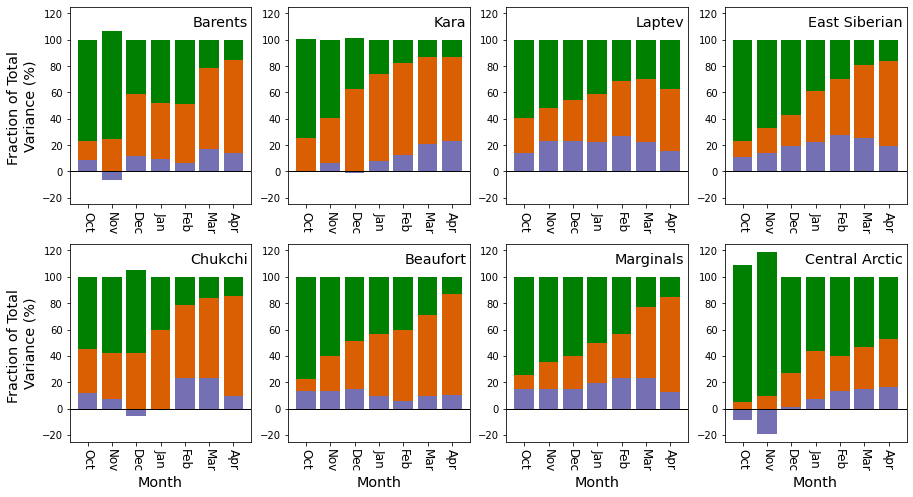

Nesosim:


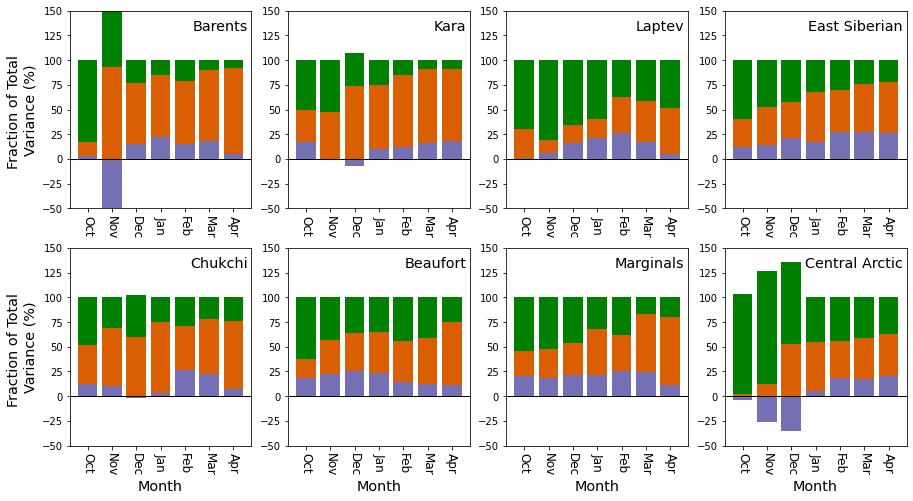

In [35]:
def rel_var_bar(c, snow_code):

    fig = plt.figure(figsize=(15,8))

    for subplot_counter, region in enumerate(region_list, 1):

        subset = c[c['region'] == region]

        fb_var = subset['freeboard_var']
        sm_var = subset['snow_var']
        covar = subset['covariance']

        mw_var = subset['mw99_snow_var']
        mw_covar = subset['mw99_cov_var']


        x = np.array(range(len(fb_var)))

        ax = plt.subplot(2,4,subplot_counter)

        totals = np.array(fb_var) + np.array(sm_var) + np.array(covar)

        fb_var_norm = np.divide(fb_var,totals)*100
        covar_norm = np.divide(covar,totals)*100
        sm_var_norm = np.divide(sm_var,totals)*100

        covar_top = [x if x > 0 else 0 for x in covar_norm]

        # Fill between 0 and covar norm

        ax.bar(x, covar_norm, color = '#7570b3',  label = 'Covariance')

        ax.bar(x,sm_var_norm, bottom = covar_top, color='#d95f02',label='SnowModel')

#         ax.bar(x, fb_var_norm, bottom = covar_top + sm_var_norm, color='#1b9e77',label='Freeboard')
        ax.bar(x, fb_var_norm, bottom = covar_top + sm_var_norm, color='green',label='Freeboard')


        ax.set_xticks([0,1,2,3,4,5,6])
        ax.set_xticklabels(month_name_list_short,
                        fontsize='large',rotation=270)

        ax.annotate(region,xy = (0.98,0.9),xycoords='axes fraction',fontsize='x-large',ha='right')
        ax.axhline(y=0, color='k', linewidth = 1)
        
        if snow_code == 'SM':
            ax.set_ylim(-25,125)
        else:
            ax.set_ylim(-50, 150)

        if subplot_counter in [1,5]:
            ax.set_ylabel('Fraction of Total \nVariance (%)', fontsize = 'x-large')

        if subplot_counter > 4:
            ax.set_xlabel('Month', fontsize = 'x-large')


    sub_dir = 'Figures' if snow_code == 'SM' else 'Sup_Figs'
    dir_to_save = f'/home/robbie/Dropbox/Apps/Overleaf/SnowModel-LG_Paper/{sub_dir}'
    fig.savefig(f'{dir_to_save}/rel_var_breakdown_{snow_code}.png',
                dpi=450, bbox_inches='tight')


    str_to_pass = f'convert {dir_to_save}/abs_var_breakdown_{snow_code}.png {dir_to_save}/rel_var_breakdown_{snow_code}.png -append {dir_to_save}/var_contribs_{snow_code}.png'
    !{str_to_pass}

    plt.show()
    
print('SnowModel-LG:')
rel_var_bar(c, 'SM')
print('Nesosim:')
rel_var_bar(c_NS, 'NS')

# Calculate the trends with mW99 and SM

/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


all
Region: Barents, Month: 11, SM: -0.04%, mW99: -0.021
Region: Barents, Month: 12, SM: -0.043%, mW99: -0.021
Region: Barents, Month: 01, SM: -0.046%, mW99: -0.022
Region: Barents, Month: 02, SM: -0.049%, mW99: -0.02
Region: Barents, Month: 03, SM: -0.053%, mW99: -0.021
Region: Barents, Month: 04, SM: -0.043%, mW99: -0.025
Region: Kara, Month: 10, SM: -0.066%, mW99: -0.039
Region: Kara, Month: 11, SM: -0.072%, mW99: -0.044
Region: Kara, Month: 12, SM: -0.059%, mW99: -0.036
Region: Kara, Month: 01, SM: -0.048%, mW99: -0.033
Region: Kara, Month: 02, SM: -0.04%, mW99: -0.023
Region: Kara, Month: 03, SM: -0.034%, mW99: -0.017
Region: Kara, Month: 04, SM: -0.032%, mW99: -0.026
Region: Laptev, Month: 10, SM: -0.048%, mW99: -0.025
Region: Laptev, Month: 11, SM: -0.05%, mW99: -0.027
Region: Laptev, Month: 12, SM: -0.038%, mW99: -0.019
Region: Laptev, Month: 01, SM: -0.032%, mW99: -0.014
Region: Laptev, Month: 02, SM: -0.029%, mW99: -0.015
Region: Laptev, Month: 03, SM: -0.026%, mW99: -0.018
R

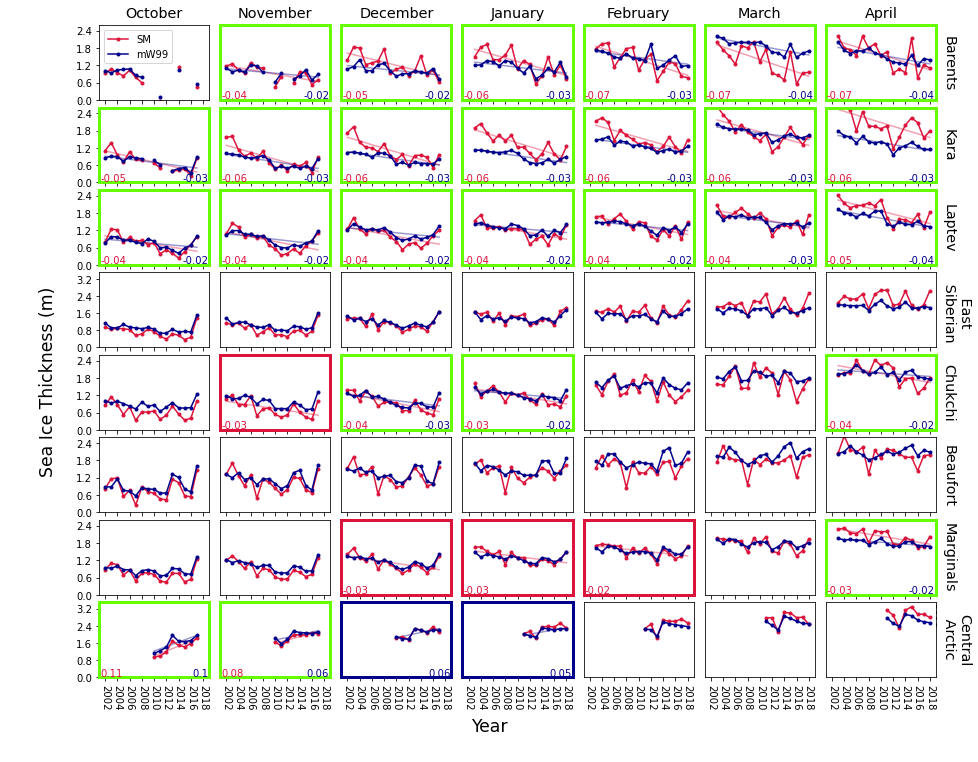

all


/home/robbie/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1541: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe')
/home/robbie/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1541: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe')
/home/robbie/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1541: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe')


Region: Barents, Month: 02, SM: -0.047%, NS: -0.0
Region: Kara, Month: 10, SM: -0.085%, NS: -0.074
Region: Kara, Month: 11, SM: -0.099%, NS: -0.063
Region: Kara, Month: 12, SM: -0.069%, NS: -0.053
Region: Kara, Month: 01, SM: -0.056%, NS: -0.042
Region: Kara, Month: 02, SM: -0.048%, NS: -0.034
Region: Kara, Month: 03, SM: -0.046%, NS: -0.0
Region: Laptev, Month: 10, SM: -0.088%, NS: -0.071
Region: Laptev, Month: 11, SM: -0.102%, NS: -0.074


/home/robbie/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1541: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe')
/home/robbie/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1541: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe')


Region: Laptev, Month: 12, SM: -0.071%, NS: -0.056
Region: Laptev, Month: 01, SM: -0.057%, NS: -0.042
Region: Laptev, Month: 02, SM: -0.044%, NS: -0.032
Region: Laptev, Month: 03, SM: -0.036%, NS: -0.026
Region: Laptev, Month: 04, SM: -0.038%, NS: -0.026
Region: East Siberian, Month: 10, SM: -0.049%, NS: -0.036
Region: East Siberian, Month: 11, SM: -0.05%, NS: -0.037
Region: East Siberian, Month: 12, SM: -0.038%, NS: -0.03
Region: Chukchi, Month: 12, SM: -0.053%, NS: -0.036
Region: Chukchi, Month: 01, SM: -0.033%, NS: -0.031
Region: Marginals, Month: 11, SM: -0.058%, NS: -0.037
Region: Marginals, Month: 12, SM: -0.045%, NS: -0.035
Region: Marginals, Month: 01, SM: -0.034%, NS: -0.0


/home/robbie/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1541: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe')
/home/robbie/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1541: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe')
/home/robbie/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1541: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe')
/home/robbie/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1541: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe')
/home/robbie/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1541: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe')


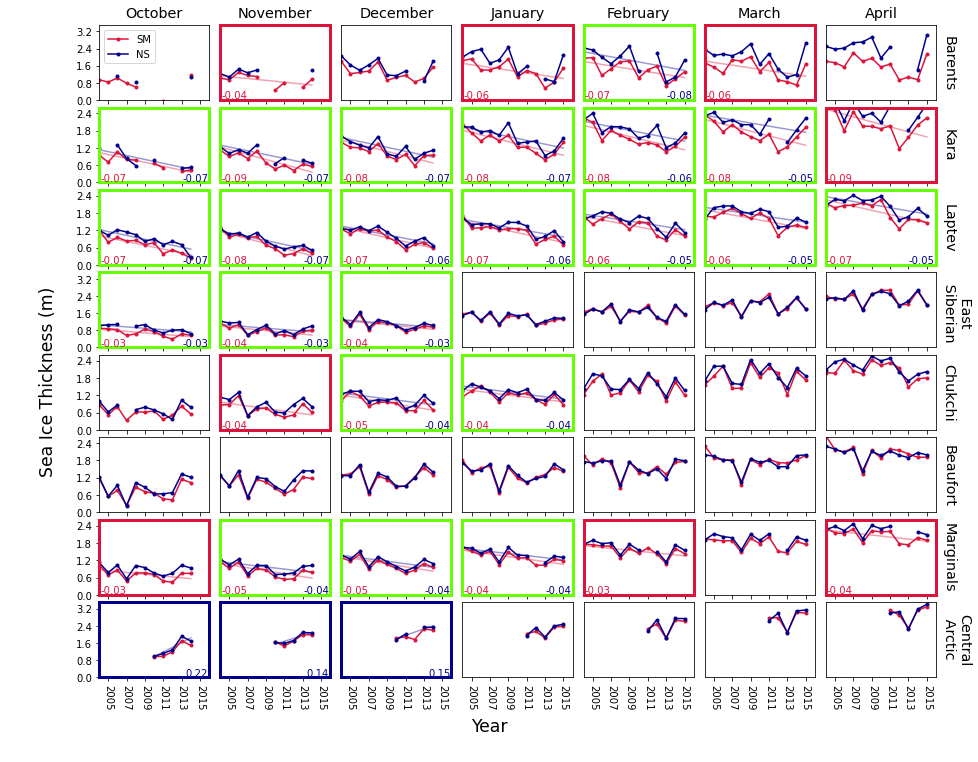

MYI
Region: Laptev, Month: 02, SM: -0.055%, mW99: -0.018
Region: Laptev, Month: 03, SM: -0.027%, mW99: -0.013
Region: Laptev, Month: 04, SM: -0.047%, mW99: -0.026
Region: Chukchi, Month: 01, SM: -0.077%, mW99: -0.024
Region: Chukchi, Month: 04, SM: -0.05%, mW99: -0.013


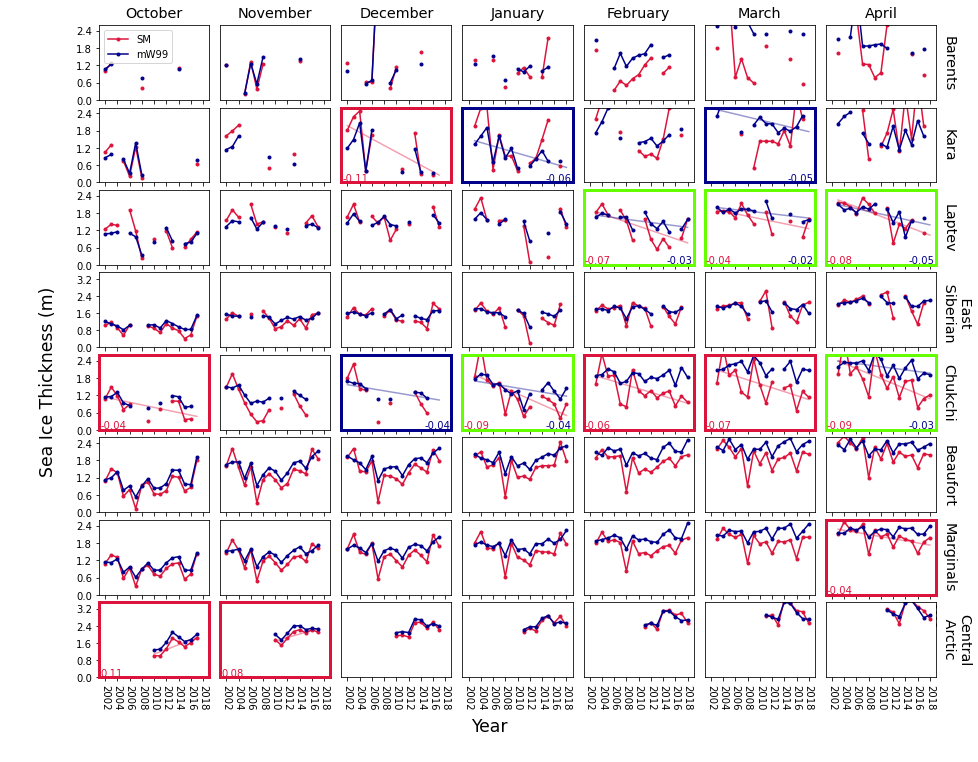

FYI
Region: Barents, Month: 11, SM: -0.04%, mW99: -0.02
Region: Barents, Month: 12, SM: -0.045%, mW99: -0.022
Region: Barents, Month: 01, SM: -0.047%, mW99: -0.022
Region: Barents, Month: 02, SM: -0.048%, mW99: -0.02
Region: Barents, Month: 03, SM: -0.052%, mW99: -0.021
Region: Barents, Month: 04, SM: -0.044%, mW99: -0.025
Region: Kara, Month: 10, SM: -0.07%, mW99: -0.037
Region: Kara, Month: 11, SM: -0.071%, mW99: -0.041
Region: Kara, Month: 12, SM: -0.057%, mW99: -0.032
Region: Kara, Month: 01, SM: -0.048%, mW99: -0.03
Region: Kara, Month: 02, SM: -0.039%, mW99: -0.022
Region: Kara, Month: 03, SM: -0.034%, mW99: -0.016
Region: Kara, Month: 04, SM: -0.033%, mW99: -0.025
Region: Laptev, Month: 02, SM: -0.027%, mW99: -0.013
Region: Laptev, Month: 03, SM: -0.025%, mW99: -0.016
Region: Laptev, Month: 04, SM: -0.029%, mW99: -0.024
Region: Chukchi, Month: 12, SM: -0.041%, mW99: -0.024
Region: Chukchi, Month: 01, SM: -0.029%, mW99: -0.014
Region: Marginals, Month: 04, SM: -0.017%, mW99: -0.0

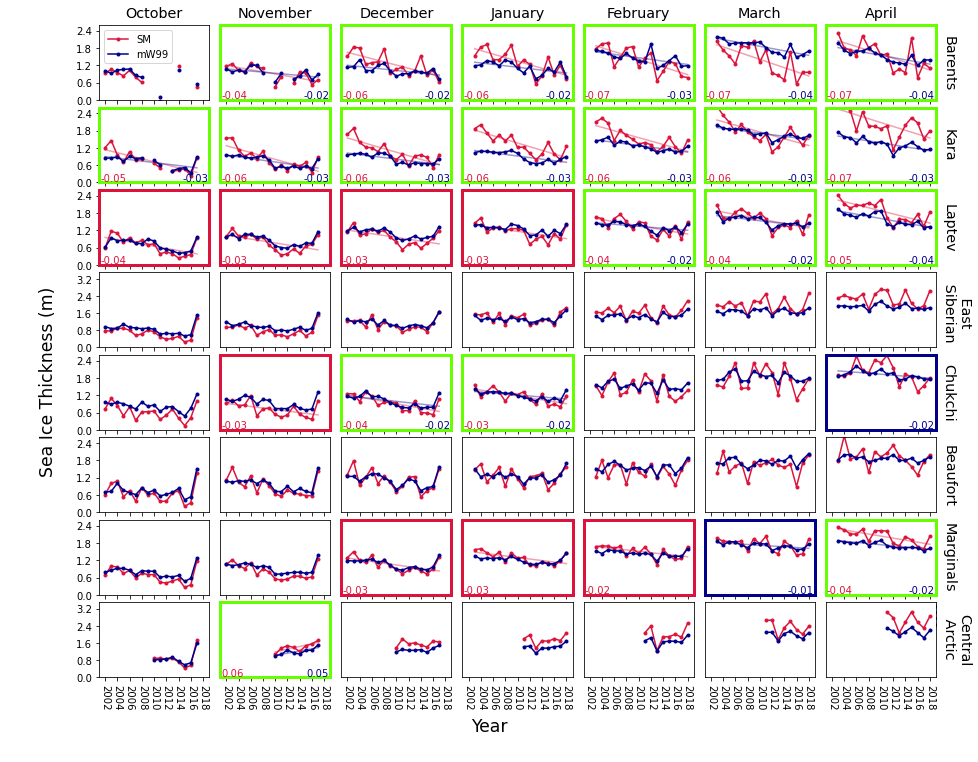

In [19]:
# monthlist = ['10', '11', '12', '01', '02', '03', '04']

def filter_df(df,start_year,end_year):
    
    df = df[(start_year <= df['year']) & (df['year'] <= end_year)]
    
    return(df)

def timeseries(ice_type,snow_product,snow_product_2):
    
    significance_increase = []
    
    trends_dict = defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))
    
    print(ice_type)

    region_annotations = {"Laptev":0.25,
                          "Kara":0.35,
                          "East Siberian":0.05,
                          "Beaufort":0.2,
                          "Central Arctic":0.05,
                          "Chukchi":0.25,
                          "Barents":0}

    ylims = {"Laptev":0.25,
              "Kara":0.35,
              "East Siberian":0.05,
              "Beaufort":0.2,
              "Central Arctic":0.05,
              "Chukchi":0.25,
              "Barents":0}

    fig = plt.figure(figsize=(15,12))
    
    for subplot_counter, (region, month) in enumerate(itertools.product(region_list,rea(month_list)),1):

        ax = plt.subplot(len(region_list),len(month_list),subplot_counter)

        subset = beta[(beta['month'] == month ) & (beta['region'] == region)]
        
        if 'NS' in [snow_product, snow_product_2]:
            
            if int(month) > 7: subset = filter_df(subset,2002,2014)
            else: subset = filter_df(subset,2002,2015)
                

        W99 = list(subset[f'{ice_type} {snow_product_2} thickness'])
            
        SM = list(subset[f'{ice_type} {snow_product} thickness'])

        yearlist = list(subset['year'])

        # Calculate statistics
        SM_stats = nanregress(yearlist,SM)
        SM_mean = np.nanmean(SM)
        W99_stats = nanregress(yearlist,W99)
        W99_mean = np.nanmean(W99)
        
        SM_detrended = detrender(yearlist,SM)
        W99_detrended = detrender(yearlist,W99)
        
        SM_std = np.nanstd(SM_detrended)
        W99_std = np.nanstd(W99_detrended)
        
        if (SM_stats[3] < 0.05) and (W99_stats[3] < 0.05):

            trends_dict[region][month] = (SM_stats[0],W99_stats[0],SM_std,W99_std,SM_mean,W99_mean)

            # Shade if SM & W99 -> Green Solid Outline
            
#             print(f'Region: {region}, Month: {month}, SM: {np.round(SM_stats[0], decimals = 3)}, mW: {np.round(W99_stats[0], decimals = 3)} Frac: {np.round((SM_stats[0]/W99_stats[0])/W99_stats[0], decimals = 3)}')
            
            print(f'Region: {region}, Month: {month}, SM: {np.round(SM_stats[0]/SM_mean, decimals = 3)}%, {snow_product_2}: {np.round(W99_stats[0]/W99_mean, decimals = 3)}')
            
            
            
            for spine in ax.spines.values():
                spine.set_edgecolor('#66ff00')
                spine.set_linewidth('3')
                
            ax.plot(yearlist, np.array(yearlist)*SM_stats[0] + SM_stats[1], color='crimson', alpha=0.4)
            ax.plot(yearlist, np.array(yearlist)*W99_stats[0] + W99_stats[1], color='darkblue', alpha=0.4)
   
            ax.annotate(np.round(SM_stats[0], decimals = 2), xy = (0.01,0.02), xycoords = 'axes fraction',color='crimson')
            ax.annotate(np.round(W99_stats[0], decimals = 2), xy = (0.99,0.02), xycoords = 'axes fraction',color='darkblue', ha='right')



        elif (SM_stats[3] < 0.05):
            
            ax.plot(yearlist, np.array(yearlist)*SM_stats[0] + SM_stats[1], color='crimson', alpha=0.4)

            trends_dict[region][month] = (SM_stats[0],np.nan, SM_std, W99_std,SM_mean,W99_mean)

            # If only SM significant -> Crimson Solid outline
            
            ax.annotate(np.round(SM_stats[0], decimals = 2), xy = (0.01,0.02), xycoords = 'axes fraction',color='crimson')


            for spine in ax.spines.values():
                spine.set_edgecolor('crimson')
                spine.set_linewidth('3')

        elif (W99_stats[3] < 0.05):
            
            ax.plot(yearlist, np.array(yearlist)*W99_stats[0] + W99_stats[1], color='darkblue', alpha=0.4)
            ax.annotate(np.round(W99_stats[0], decimals = 2), xy = (0.99,0.02), xycoords = 'axes fraction',color='darkblue', ha='right')


            trends_dict[region][month] = (np.nan ,W99_stats[0], SM_std, W99_std,SM_mean,W99_mean)

            # If only W99 significant -> Darkblue Solid outline

            for spine in ax.spines.values():
                spine.set_edgecolor('darkblue')
                spine.set_linewidth('3')

        else:

            trends_dict[region][month] = (np.nan,np.nan,SM_std, W99_std,SM_mean,W99_mean)


        ax.plot(yearlist,SM,
                      marker='.',label=snow_product,color='crimson')

        ax.plot(yearlist,W99,
                      marker='.',label=snow_product_2,color='darkblue')





        # Set appropriate y axis limits
        
        big_lims = ["Central Arctic",  "East Siberian", "Barents"] if 'NS' in [snow_product, snow_product_2] else ["Central Arctic",  "East Siberian"]

        if region in big_lims:
            ax.set_ylim(0,3.5)
        else:
            ax.set_ylim(0,2.6)


        # Make month name annotations

        if subplot_counter <= len(month_list):

            ax.annotate(month_name_list_full[subplot_counter-1],
                              xy = (0.5,1.1),xycoords='axes fraction',
                              fontsize="x-large",ha='center')


        # Make region name annotations

        if subplot_counter% 7 == 0:
            
            if region == 'Central Arctic':
                region_name = 'Central\n Arctic'
            elif region == 'East Siberian':
                region_name = '    East\n Siberian'
            else:
                region_name = region
            
            ax.annotate(region_name,xy = (1.05,0.5),
                              xycoords='axes fraction',
                              fontsize='x-large',
                              va='center',
                              ha='left',
                              rotation=270)

        # Make y ticks depending on ylims

        if region in big_lims:
            yticks = np.linspace(0,3.2,5)
            yticks = np.around(yticks,decimals=2)
        else:
            yticks = np.linspace(0,2.4,5)
            yticks = np.around(yticks,decimals=2)

        if subplot_counter % 7 == 1:

            ax.set_yticks(ticks=yticks)
            ax.set_yticklabels(yticks)
        else:
            ax.set_yticks(ticks=[])

        # Make x ticks
        
        if 'NS' in [snow_product, snow_product_2]:
            xticks = range(2005,2016,2)
            ax.set_xlim(2004,2016)            
        else:
            xticks = range(2002,2019,2)
            ax.set_xlim(2001,2019)

        
        if subplot_counter < len(month_list)*(len(region_list)-1):
            ax.set_xticks(ticks=xticks)
            ax.set_xticklabels([])
        else:
            ax.set_xticks(xticks)
            ax.tick_params('x',rotation = 270)
            
        # Annotate trends
         

        # Make legend

        if subplot_counter == 1:
            plt.legend(fontsize='medium',loc='upper left')


    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.annotate("Sea Ice Thickness (m)",
                 xy = (0.04,0.5),
                 xycoords="figure fraction",
                 rotation=90,
                 fontsize="xx-large",
                 va='center')

    plt.annotate("Year",
                 xy = (0.5,0.04),
                 xycoords="figure fraction",
                 fontsize="xx-large",
                 ha='center')
    
    
    sub_dir = 'Figures' if snow_product == 'SM' else 'Sup_Figs'
    dir_to_save = f'/home/robbie/Dropbox/Apps/Overleaf/SnowModel-LG_Paper/{sub_dir}'
    fig.savefig(f"{dir_to_save}/{snow_product}_{snow_product_2}_{ice_type}_thickness_timeseries.png",
                dpi=450, bbox_inches='tight')

    
    plt.show()
    
    return(trends_dict)

    
all_trends_dict = timeseries('all','SM','mW99')
all_trends_dict_NS = timeseries('all', 'SM', 'NS')
MYI_trends_dict = timeseries('MYI','SM','mW99')
FYI_trends_dict = timeseries('FYI','SM','mW99')

/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


region:Laptev, W99:-0.02421643353861492, SM:-0.041164361722813105
% increase: 0.6998523608843327
region:Kara, W99:-0.030474655941269326, SM:-0.060358150840434645
% increase: 0.9806015515567004
region:Chukchi, W99:-0.01945412242125148, SM:-0.03858004088280658
% increase: 0.9831293361587028
region:Barents, W99:-0.028654682141242976, SM:-0.0591427433830058
% increase: 1.0639818334568452


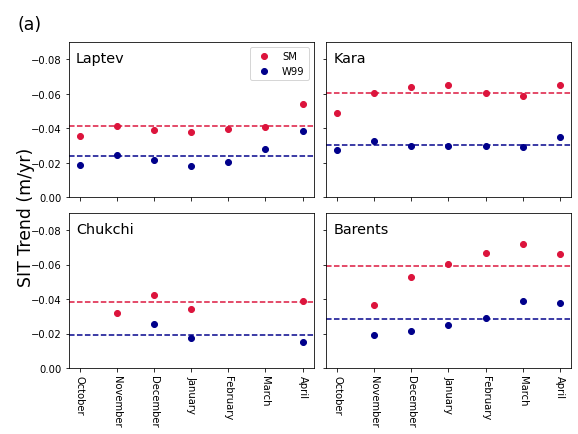

In [26]:

def abs_trends_summary(all_trends_dict):

    fig = plt.figure(figsize=(9,6))

    for subplot_counter, key in enumerate(['Laptev', 'Kara', 'Chukchi', 'Barents'], 1):

        ax = plt.subplot(2,2,subplot_counter)

        region_data = all_trends_dict[key]

    #     print(region_data)

        SM_trends, W99_trends = [], []
        SM_trends_m, W99_trends_m = [], []

        for month in rea(month_list):
            
            SM_trends.append(region_data[month][0])
            W99_trends.append(region_data[month][1])
            
            if ~np.isnan(region_data[month]).any():
                SM_trends_m.append(region_data[month][0])
                W99_trends_m.append(region_data[month][1])
        
        W99_ave = np.nanmean(W99_trends_m)
        SM_ave = np.nanmean(SM_trends_m)

    #     print(key,np.around(SM_ave,decimals=3),np.around(W99_ave,decimals=3),np.around(SM_ave-W99_ave,decimals))

        ax.axhline(SM_ave,color='crimson',linestyle='--')

        ax.axhline(W99_ave,color='darkblue',linestyle='--')

        print(f'region:{key}, W99:{W99_ave}, SM:{SM_ave}')
        print(f'% increase: {(SM_ave-W99_ave)/W99_ave}')

        ax.scatter(month_name_list_full,SM_trends,label='SM',color='crimson')

        ax.scatter(month_name_list_full,W99_trends,label='W99',color='darkblue')

        # Legend

        if subplot_counter == 1: ax.legend(loc='upper right')

        # x ticks

        if subplot_counter in [1,2]:
            ax.set_xticks(ticks=month_name_list_full)
            ax.set_xticklabels([])
        else:
            ax.set_xticks(ticks=month_name_list_full)
            ax.set_xticklabels(month_name_list_full,rotation = 270)

        # y ticks

        yticks = np.linspace(0,-0.08,5)

        if subplot_counter in [2,4]:
            ax.set_yticks(ticks=yticks)
            ax.set_yticklabels([])
        else:
            ax.set_yticks(ticks=yticks)

        ax.set_ylim(0,-0.09)

        ax.annotate(key,
                          xy = (0.03,0.87),xycoords='axes fraction',
                          ha='left',fontsize="x-large",color='k')



    plt.subplots_adjust(wspace=0.05, hspace=0.1)

    plt.annotate("SIT Trend (m/yr)",
                     xy = (0.03,0.5),
                     xycoords="figure fraction",
                     rotation=90,
                     fontsize="xx-large",
                     va='center')

    plt.annotate("(a)",
                     xy = (0.03,0.93),
                     xycoords="figure fraction",
                     fontsize="xx-large",
                     ha='left')
    
    a_fig_name = "trend_comparison_absolute.png"

    plt.savefig(a_fig_name,dpi=600,bbox_inches='tight')

    plt.show()

abs_trends_summary(all_trends_dict)
# abs_trends_summary(all_trends_dict_NS)

/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


region:Laptev, W99:-2.0376582435621193, SM:-3.6029589207112287
percent increase: 0.7681860695210296
region:Kara, W99:-3.1051838144167077, SM:-5.013019977593982
percent increase: 0.6144036157600709
region:Chukchi, W99:-1.5659573513845964, SM:-3.4224104093569117
percent increase: 1.1855067804566113
region:Barents, W99:-2.153990125609091, SM:-4.556003061207661
percent increase: 1.1151457506887803


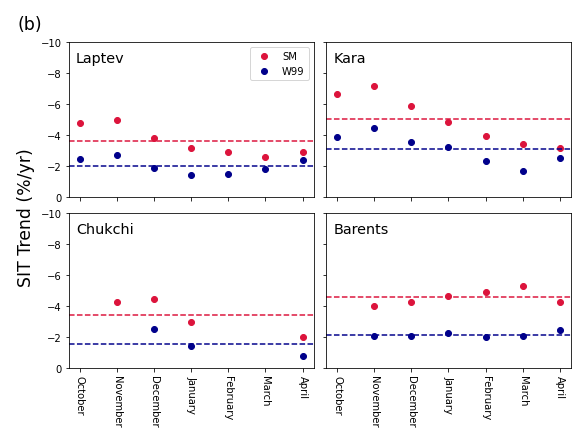

In [27]:
fig = plt.figure(figsize=(9,6))

for subplot_counter, key in enumerate(['Laptev', 'Kara', 'Chukchi', 'Barents'], 1):

    region_data = all_trends_dict[key]
    
    SM_trends, W99_trends = [], []
    SM_means, W99_means = [], []
    
    for month in rea(month_list):
        SM_trends.append(region_data[month][0])
        SM_means.append(region_data[month][-2])
        W99_trends.append(region_data[month][1])
        W99_means.append(region_data[month][-1])
        
    SM_trends = np.divide(SM_trends,SM_means)*100
    W99_trends = np.divide(W99_trends,W99_means)*100
        
    W99_ave = np.nanmean(W99_trends)
    SM_ave = np.nanmean(SM_trends)
    
    if key == 'Marginals':
        print(f'SM_std: {SM_ave}, W99_std: {W99_ave}')
    
#     print(key,np.around(SM_ave,decimals=3),np.around(W99_ave,decimals=3),np.around(SM_ave-W99_ave,decimals))

    print(f'region:{key}, W99:{W99_ave}, SM:{SM_ave}')
    print(f'percent increase: {(SM_ave-W99_ave)/W99_ave}')
    
    ax = plt.subplot(2,2,subplot_counter)
    
    ax.axhline(SM_ave,color='crimson',linestyle='--')
    
    ax.axhline(W99_ave,color='darkblue',linestyle='--')
    
    ax.scatter(month_name_list_full,SM_trends,label='SM',color='crimson')
    
    ax.scatter(month_name_list_full,W99_trends,label='W99',color='darkblue')
    
    if subplot_counter in [2,4]:
        ax.set_yticklabels([])
    
    # Legend
    
    if subplot_counter == 1:
        ax.legend(loc='upper right')
    
    # x ticks
    
    if subplot_counter in [1,2]:
        ax.set_xticks(ticks=month_name_list_full)
        ax.set_xticklabels([])
    else:
        ax.set_xticks(ticks=month_name_list_full)
        ax.set_xticklabels(month_name_list_full,rotation = 270)
    
    # y ticks
    
#     yticks = np.linspace(0,-0.08,5)
    
        
    ax.set_ylim(0,-10)

    # Region Annotation
    
    xy = (0.03,0.87)
    
    ax.annotate(key,
                      xy = xy,xycoords='axes fraction',
                      ha='left',fontsize="x-large",color='k')
    
    
    
plt.subplots_adjust(wspace=0.05, hspace=0.1)

plt.annotate("SIT Trend (%/yr)",
                 xy = (0.03,0.5),
                 xycoords="figure fraction",
                 rotation=90,
                 fontsize="xx-large",
                 va='center')

plt.annotate("(b)",
                 xy = (0.03,0.93),
                 xycoords="figure fraction",
                 fontsize="xx-large",
                 ha='left')

b_fig_name = "trend_comparison_percent.png"

plt.savefig(b_fig_name,dpi=600,bbox_inches='tight')

plt.show()

dir_to_combine = '/home/robbie/Dropbox/Apps/Overleaf/SnowModel-LG_Paper/Figures/'
str_to_pass = f'convert {a_fig_name} {b_fig_name} -append {dir_to_combine}output_trends.png'
!{str_to_pass}

/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


region:Barents, W99:0.15976723316566693, SM:0.28655469455395105, %inc: 0.7935761224381648
region:Kara, W99:0.11131271336209969, SM:0.24594923281260045, %inc: 1.2095340719305696
region:Laptev, W99:0.1313459158193408, SM:0.2264011076021031, %inc: 0.7237011610890558
region:East Siberian, W99:0.16385179204324968, SM:0.2713819855780232, %inc: 0.6562649830914895
[0.24302803874773835, 0.26130898509937733, 0.2626719869045327, 0.25183800737507883, 0.2685019029348088, 0.3075519553401952, 0.3047730226444313]
region:Chukchi, W99:0.14221199316002425, SM:0.24298447635233805, %inc: 0.7086074876886046
region:Beaufort, W99:0.20763588440696928, SM:0.2938216510042576, %inc: 0.4150812700003387
region:Marginals, W99:0.12222100054466621, SM:0.19138769582963583, %inc: 0.5659149816867384
region:Central Arctic, W99:0.1528964089583281, SM:0.1935678617006995, %inc: 0.2660065924338119


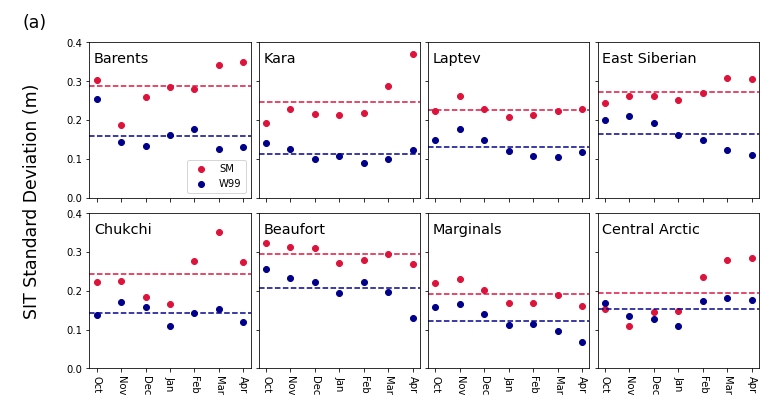

In [38]:
fig = plt.figure(figsize=(12,6))

for subplot_counter, key in enumerate(region_list, 1):
    
    ax = plt.subplot(2,4,subplot_counter)
    
    region_data = all_trends_dict[key]

    SM_trends, W99_trends = [], []
    
    for month in rea(month_list):
        
        SM_trends.append(region_data[month][2])
        W99_trends.append(region_data[month][3])
        
    W99_ave = np.nanmean(W99_trends)
    SM_ave = np.nanmean(SM_trends)
    
    ax.axhline(SM_ave,color='crimson',linestyle='--')
    
    ax.axhline(W99_ave,color='darkblue',linestyle='--')
    
    print(f'region:{key}, W99:{W99_ave}, SM:{SM_ave}, %inc: {(SM_ave-W99_ave)/W99_ave}')
    
    ax.scatter(month_name_list_full,SM_trends,label='SM',color='crimson')
    
    ax.scatter(month_name_list_full,W99_trends,label='W99',color='darkblue')
    
    if key == 'East Siberian':
        print(SM_trends)
    
    # Legend
    
    if subplot_counter == 1:
        ax.legend(loc='lower right')
        
    ax.annotate(key,
                  xy = (0.03,0.87),xycoords='axes fraction',
                  ha='left',fontsize="x-large",color='k')
    
    ax.set_ylim(0,0.4)
    
    if subplot_counter in [2,3,4,6,7,8]:
        ax.set_yticklabels([])
    
    if subplot_counter in [1,2,3,4]:
        ax.set_xticks(ticks=month_name_list_full)
        ax.set_xticklabels([])
    else:
        ax.set_xticks(ticks=month_name_list_full)
        ax.set_xticklabels(month_name_list_short,rotation = 270)

    

    
plt.subplots_adjust(wspace=0.05, hspace=0.1)

plt.annotate("SIT Standard Deviation (m)",
                 xy = (0.03,0.5),
                 xycoords="figure fraction",
                 rotation=90,
                 fontsize="xx-large",
                 va='center')

plt.annotate("(a)",
                 xy = (0.03,0.93),
                 xycoords="figure fraction",
                 fontsize="xx-large",
                 ha='left')

a_var_fig_name="variation_comparison_absolute.png"
plt.savefig(a_var_fig_name,dpi=600,bbox_inches='tight')

plt.show()


/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


region:Barents, W99:14.181418335361146, SM:24.309322025727187, %inc: 10.127903690366042
region:Kara, W99:11.70100272892888, SM:19.679896390672827, %inc: 7.978893661743946
region:Laptev, W99:11.970235411233366, SM:20.545169372581277, %inc: 8.574933961347911
region:East Siberian, W99:13.32593473166027, SM:21.579614515253503, %inc: 8.253679783593233
[33.73305868 30.72984052 23.44187876 17.86717977 16.17540169 15.6157178
 13.49422439]
region:Chukchi, W99:11.628294607093332, SM:21.628617683445487, %inc: 10.000323076352155
region:Beaufort, W99:15.208789056018022, SM:23.179364582547837, %inc: 7.9705755265298155
SM_std: 16.624773146537184, W99_std: 10.365934411983869
region:Marginals, W99:10.365934411983869, SM:16.624773146537184, %inc: 6.258838734553315
region:Central Arctic, W99:7.11367265353291, SM:8.569604375103756, %inc: 1.4559317215708463


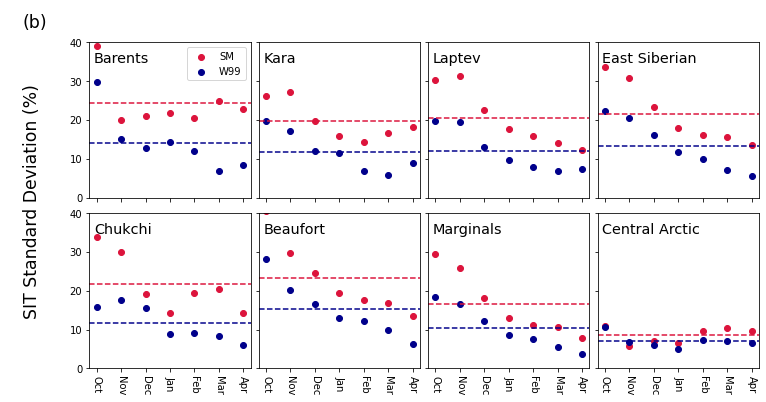

In [39]:
fig = plt.figure(figsize=(12,6))

for subplot_counter, key in enumerate(region_list, 1):
    
    ax = plt.subplot(2,4,subplot_counter)
    
    region_data = all_trends_dict[key]

    SM_trends, W99_trends = [], []
    SM_means, W99_means = [], []
    
    for month in rea(month_list):
        
        SM_trends.append(region_data[month][2])
        SM_means.append(region_data[month][-2])
        W99_trends.append(region_data[month][3])
        W99_means.append(region_data[month][-1])
        
    SM_trends = np.divide(SM_trends,SM_means)*100
    W99_trends = np.divide(W99_trends,W99_means)*100
    
    W99_ave = np.nanmean(W99_trends)
    SM_ave = np.nanmean(SM_trends)
    
    if key == 'Marginals':
        print(f'SM_std: {SM_ave}, W99_std: {W99_ave}')
    
    ax.axhline(SM_ave,color='crimson',linestyle='--')
    
    ax.axhline(W99_ave,color='darkblue',linestyle='--')
    
    print(f'region:{key}, W99:{W99_ave}, SM:{SM_ave}, %inc: {(SM_ave-W99_ave)}')
    
    ax.scatter(month_name_list_full,SM_trends,label='SM',color='crimson')
    
    ax.scatter(month_name_list_full,W99_trends,label='W99',color='darkblue')
    
    if key == 'East Siberian':
        print(SM_trends)
    
    # Legend
    
    if subplot_counter == 1:
        ax.legend(loc='upper right')
        
    ax.annotate(key,
                  xy = (0.03,0.87),xycoords='axes fraction',
                  ha='left',fontsize="x-large",color='k')
    
    ax.set_ylim(0,40)
    
    if subplot_counter in [2,3,4,6,7,8]:
        ax.set_yticklabels([])
    
    if subplot_counter in [1,2,3,4]:
        ax.set_xticks(ticks=month_name_list_full)
        ax.set_xticklabels([])
    else:
        ax.set_xticks(ticks=month_name_list_full)
        ax.set_xticklabels(month_name_list_short,rotation = 270)
        

    
plt.subplots_adjust(wspace=0.05, hspace=0.1)

plt.annotate("SIT Standard Deviation (%)",
                 xy = (0.03,0.5),
                 xycoords="figure fraction",
                 rotation=90,
                 fontsize="xx-large",
                 va='center')

plt.annotate("(b)",
                 xy = (0.03,0.93),
                 xycoords="figure fraction",
                 fontsize="xx-large",
                 ha='left')

b_var_fig_name = "variation_comparison_percent.png"
plt.savefig(b_var_fig_name,dpi=600,bbox_inches='tight')

plt.show()


dir_to_combine = '/home/robbie/Dropbox/Apps/Overleaf/SnowModel-LG_Paper/Figures/'
str_to_pass = f'convert {a_var_fig_name} {b_var_fig_name} -append {dir_to_combine}output_vars.png'
!{str_to_pass}

# Now calculate variability by ice type

/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


region:Barents, W99:0.28646415449388407, SM:0.6722929107009673, %inc: 1.3468657427270558
region:Kara, W99:0.24637733380902097, SM:0.652876055100988, %inc: 1.6499030775577106
region:Laptev, W99:0.21760752615834703, SM:0.35341860469237424, %inc: 0.6241102085559358
region:East Siberian, W99:0.2689690196565852, SM:0.3524396677773619, %inc: 0.3103355480395122
[0.26373698603328777, 0.26074413328076634, 0.3096773117923391, 0.46014803646577696, 0.34943395489886087, 0.43548338707791373, 0.3878538648925887]
region:Chukchi, W99:0.25839853928186785, SM:0.4184774151245084, %inc: 0.6195037955227076
region:Beaufort, W99:0.2869174526705093, SM:0.394279797237345, %inc: 0.3741924500149828
region:Marginals, W99:0.18501294955864028, SM:0.32516219584261624, %inc: 0.7575104695012461
region:Central Arctic, W99:0.25070929753947985, SM:0.2555227558918535, %inc: 0.01919936117094218


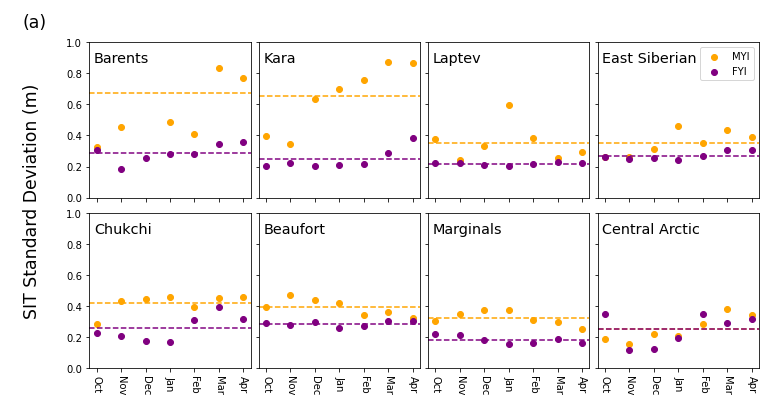

In [36]:
fig = plt.figure(figsize=(12,6))

for subplot_counter, key in enumerate(region_list, 1):
    
    ax = plt.subplot(2,4,subplot_counter)
    
    MYI_region_data = MYI_trends_dict[key]
    FYI_region_data = FYI_trends_dict[key]


    SM_trends, W99_trends = [], []
    
    for month in rea(month_list):
        
        SM_trends.append(MYI_region_data[month][2])
        W99_trends.append(FYI_region_data[month][2])
        
    W99_ave = np.nanmean(W99_trends)
    SM_ave = np.nanmean(SM_trends)
    
    ax.axhline(SM_ave,color='orange',linestyle='--')
    
    ax.axhline(W99_ave,color='purple',linestyle='--')
    
    print(f'region:{key}, W99:{W99_ave}, SM:{SM_ave}, %inc: {(SM_ave-W99_ave)/W99_ave}')
    
    ax.scatter(month_name_list_full,SM_trends,label='MYI',color='orange')
    
    ax.scatter(month_name_list_full,W99_trends,label='FYI',color='purple')
    
    if key == 'East Siberian':
        print(SM_trends)
    
    # Legend
    
    if subplot_counter == 4:
        ax.legend(loc='upper right')
        
    ax.annotate(key,
                  xy = (0.03,0.87),xycoords='axes fraction',
                  ha='left',fontsize="x-large",color='k')
    
    ax.set_ylim(0,1)
    
    if subplot_counter in [2,3,4,6,7,8]:
        ax.set_yticklabels([])
    
    if subplot_counter in [1,2,3,4]:
        ax.set_xticks(ticks=month_name_list_full)
        ax.set_xticklabels([])
    else:
        ax.set_xticks(ticks=month_name_list_full)
        ax.set_xticklabels(month_name_list_short,rotation = 270)

    

    
plt.subplots_adjust(wspace=0.05, hspace=0.1)

plt.annotate("SIT Standard Deviation (m)",
                 xy = (0.03,0.5),
                 xycoords="figure fraction",
                 rotation=90,
                 fontsize="xx-large",
                 va='center')

plt.annotate("(a)",
                 xy = (0.03,0.93),
                 xycoords="figure fraction",
                 fontsize="xx-large",
                 ha='left')

a_var_fig_name="ice_type_rel_variability_abs.png"
plt.savefig(a_var_fig_name,dpi=600,bbox_inches='tight')

plt.show()



/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


region:Barents, W99:14.178524147501212, SM:52.09399618546536, %inc: 37.91547203796414
region:Kara, W99:11.903189994183247, SM:43.4143165359075, %inc: 31.511126541724256
region:Laptev, W99:12.418785141529595, SM:25.332783847687466, %inc: 12.913998706157871
region:East Siberian, W99:13.719465654988028, SM:23.532203872122732, %inc: 9.812738217134704
[29.301773   19.68937187 20.63278964 31.7435033  20.81516638 23.65537173
 18.88745119]
region:Chukchi, W99:12.160994931884364, SM:34.170833046203754, %inc: 22.00983811431939
region:Beaufort, W99:15.24565483780756, SM:26.54927233585391, %inc: 11.30361749804635
SM_std: 22.6744810954635, W99_std: 11.024451447431824
region:Marginals, W99:11.024451447431824, SM:22.6744810954635, %inc: 11.650029648031675
region:Central Arctic, W99:11.254419088700788, SM:10.462822709829368, %inc: -0.7915963788714198


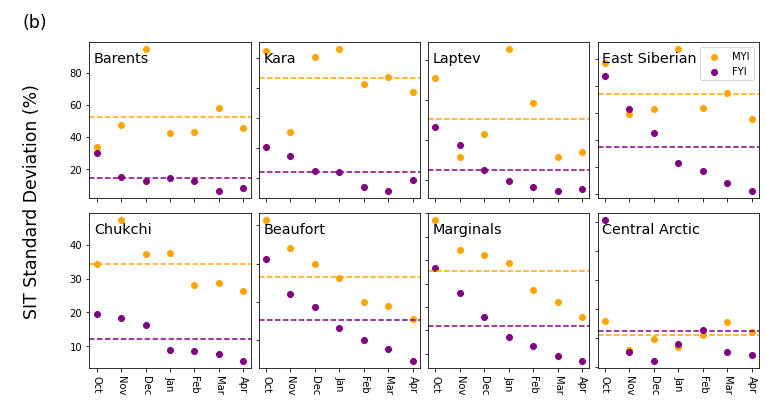

In [37]:
fig = plt.figure(figsize=(12,6))

for subplot_counter, key in enumerate(region_list, 1):
    
    ax = plt.subplot(2,4,subplot_counter)
    
    MYI_region_data = MYI_trends_dict[key]
    FYI_region_data = FYI_trends_dict[key]


    SM_trends, W99_trends = [], []
    SM_means, W99_means = [], []
    
    for month in rea(month_list):
        
        SM_trends.append(MYI_region_data[month][2])
        SM_means.append(MYI_region_data[month][-2])
        W99_trends.append(FYI_region_data[month][3])
        W99_means.append(FYI_region_data[month][-1])
        
    SM_trends = np.divide(SM_trends,SM_means)*100
    W99_trends = np.divide(W99_trends,W99_means)*100
    
    W99_ave = np.nanmean(W99_trends)
    SM_ave = np.nanmean(SM_trends)
    
    if key == 'Marginals':
        print(f'SM_std: {SM_ave}, W99_std: {W99_ave}')
    
    ax.axhline(SM_ave,color='orange',linestyle='--')
    
    ax.axhline(W99_ave,color='purple',linestyle='--')
    
    print(f'region:{key}, W99:{W99_ave}, SM:{SM_ave}, %inc: {(SM_ave-W99_ave)}')
    
    ax.scatter(month_name_list_full,SM_trends,label='MYI',color='orange')
    
    ax.scatter(month_name_list_full,W99_trends,label='FYI',color='purple')
    
    if key == 'East Siberian':
        print(SM_trends)
    
    # Legend
    
    if subplot_counter == 4:
        ax.legend(loc='upper right')
        
    ax.annotate(key,
                  xy = (0.03,0.87),xycoords='axes fraction',
                  ha='left',fontsize="x-large",color='k')
    
#     ax.set_ylim(0,40)
    
    if subplot_counter in [2,3,4,6,7,8]:
        ax.set_yticklabels([])
    
    if subplot_counter in [1,2,3,4]:
        ax.set_xticks(ticks=month_name_list_full)
        ax.set_xticklabels([])
    else:
        ax.set_xticks(ticks=month_name_list_full)
        ax.set_xticklabels(month_name_list_short,rotation = 270)
        

    
plt.subplots_adjust(wspace=0.05, hspace=0.1)

plt.annotate("SIT Standard Deviation (%)",
                 xy = (0.03,0.5),
                 xycoords="figure fraction",
                 rotation=90,
                 fontsize="xx-large",
                 va='center')

plt.annotate("(b)",
                 xy = (0.03,0.93),
                 xycoords="figure fraction",
                 fontsize="xx-large",
                 ha='left')

b_var_fig_name="ice_type_rel_variability_rel.png"
plt.savefig(b_var_fig_name,dpi=600,bbox_inches='tight')

plt.show()

dir_to_combine = '/home/robbie/Dropbox/Apps/Overleaf/SnowModel-LG_Paper/Sup_Figs/'
str_to_pass = f'convert {a_var_fig_name} {b_var_fig_name} -append {dir_to_combine}ice_type_variabilities.png'
!{str_to_pass}

/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


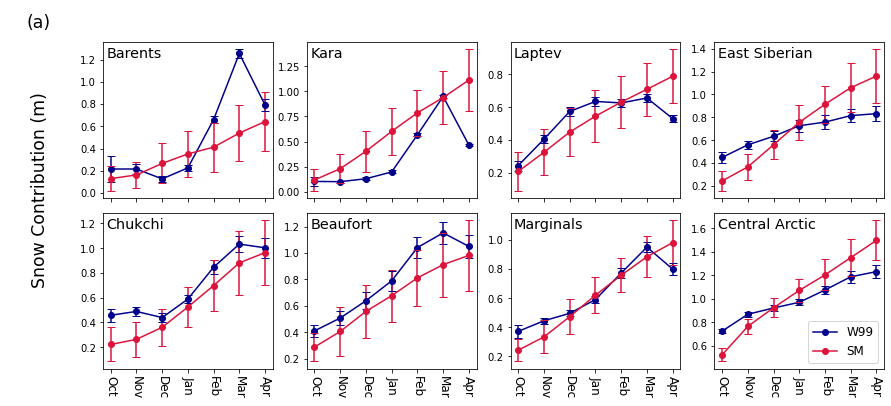

In [42]:
_avefig = plt.figure(figsize=(14,6))

for subplot_counter, region in enumerate(region_list,1):
    
    ax = plt.subplot(2,4,subplot_counter)
    
    W99_seasonal_ave = seasonal['all mW99 contribution'][region]
    SM_seasonal_ave = seasonal['all SM contribution'][region]
    
    
    W99_seasonal_std = seasonal_std['all mW99 contribution'][region]
    SM_seasonal_std = seasonal_std['all SM contribution'][region]

    
    ax.plot(rea(W99_seasonal_ave.keys()),
             rea(W99_seasonal_ave),
             color='darkblue',
             marker='o',
             label = 'W99')
    
    ax.errorbar(rea(W99_seasonal_ave.keys()),
                 rea(W99_seasonal_ave),
                 yerr=rea(W99_seasonal_std),
                 ecolor='darkblue',
                 ls='none',
                 capsize=4)
    
    ##############################################
    
    ax.plot(rea(SM_seasonal_ave.keys()),
             rea(SM_seasonal_ave),
             marker='o',
             color='crimson',
             label = 'SM')
    
    ax.errorbar(rea(SM_seasonal_ave.keys()),
                 rea(SM_seasonal_ave),
                 yerr=rea(SM_seasonal_std),
                 ecolor='crimson',
                 ls='none',
                 capsize=4)
    
    ax.annotate(region,xy = (0.02,0.9),xycoords='axes fraction',fontsize='x-large')

    
    if subplot_counter <= 4:
        ax.set_xticks(ticks=rea(SM_seasonal_ave.keys()))
        ax.set_xticklabels([])
    else:
        ax.set_xticks(ticks=rea(SM_seasonal_ave.keys()))
        ax.set_xticklabels(month_name_list_short,rotation=270,fontsize='large')

    
    if subplot_counter == 8:
        plt.legend(fontsize='large',loc='lower right')
    
plt.subplots_adjust(wspace=0.2, hspace=0.1)

plt.annotate("Snow Contribution (m)",
             xy = (0.035,0.3),
             xycoords="figure fraction",
             rotation=90,
             fontsize="xx-large")

plt.annotate("(a)",
                 xy = (0.03,0.93),
                 xycoords="figure fraction",
                 fontsize="xx-large",
                 ha='left')

dir_to_save = f'/home/robbie/Dropbox/Apps/Overleaf/SnowModel-LG_Paper/Sup_Figs'
fig.savefig(f"{dir_to_save}/seasonal_snow_contrib.png",
            dpi=450, bbox_inches='tight')
plt.show()




/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


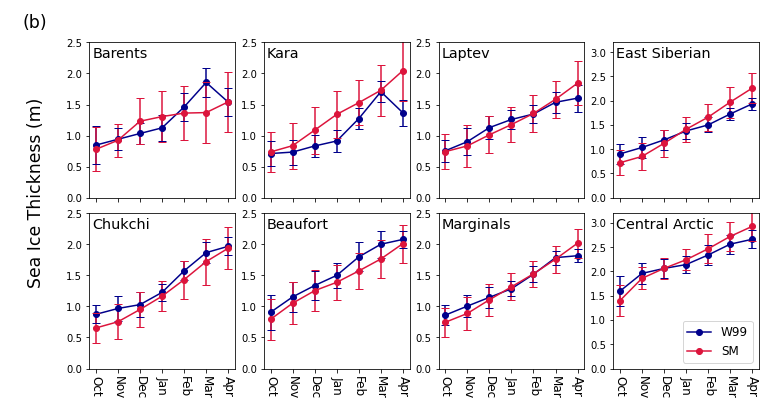

In [43]:
fig = plt.figure(figsize=(12,6))

for subplot_counter, region in enumerate(region_list,1):
    
    ax = plt.subplot(2,4,subplot_counter)
    
    W99_seasonal_ave = seasonal['all mW99 thickness'][region]
    SM_seasonal_ave = seasonal['all SM thickness'][region]
    
    
    W99_seasonal_std = seasonal_std['all mW99 thickness'][region]
    SM_seasonal_std = seasonal_std['all SM thickness'][region]

    
    ax.plot(rea(W99_seasonal_ave.keys()),
             rea(W99_seasonal_ave),
             color='darkblue',
             marker='o',
             label = 'W99')
    
    ax.errorbar(rea(W99_seasonal_ave.keys()),
                 rea(W99_seasonal_ave),
                 yerr=rea(W99_seasonal_std),
                 ecolor='darkblue',
                 ls='none',
                 capsize=4)
    
    ##############################################
    
    ax.plot(rea(SM_seasonal_ave.keys()),
             rea(SM_seasonal_ave),
             marker='o',
             color='crimson',
             label = 'SM')
    
    ax.errorbar(rea(SM_seasonal_ave.keys()),
                 rea(SM_seasonal_ave),
                 yerr=rea(SM_seasonal_std),
                 ecolor='crimson',
                 ls='none',
                 capsize=4)
    
    ax.annotate(region,xy = (0.02,0.9),xycoords='axes fraction',fontsize='x-large')

    
    if subplot_counter <= 4:
        ax.set_xticks(ticks=rea(SM_seasonal_ave.keys()))
        ax.set_xticklabels([])
    else:
        ax.set_xticks(ticks=rea(SM_seasonal_ave.keys()))
        ax.set_xticklabels(month_name_list_short,rotation=270,fontsize='large')
    
    if region in ['Central Arctic', 'East Siberian']:
        ax.set_ylim(0,3.2)
    else:
        ax.set_ylim(0,2.5)
    
    if subplot_counter == 8:
        ax.legend(fontsize='large',loc='lower right')
    
plt.subplots_adjust(wspace=0.2, hspace=0.1)

plt.annotate("Sea Ice Thickness (m)",
             xy = (0.035,0.3),
             xycoords="figure fraction",
             rotation=90,
             fontsize="xx-large")

plt.annotate("(b)",
                 xy = (0.03,0.93),
                 xycoords="figure fraction",
                 fontsize="xx-large",
                 ha='left')

dir_to_save = f'/home/robbie/Dropbox/Apps/Overleaf/SnowModel-LG_Paper/Sup_Figs'
fig.savefig(f"{dir_to_save}/seasonal_SIT_contrib.png",
            dpi=450, bbox_inches='tight')
plt.show()

str_to_pass = f'convert {dir_to_save}/seasonal_snow_contrib.png {dir_to_save}/seasonal_SIT_contrib.png -append {dir_to_save}/seasonal_composite.png'
!{str_to_pass}



# Check trends are the same for E5 & M2

/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


all
Region: Barents, Month: 11, SM: -0.036, mW: -0.037
Region: Barents, Month: 12, SM: -0.052, mW: -0.054
Region: Barents, Month: 01, SM: -0.059, mW: -0.062
Region: Barents, Month: 02, SM: -0.063, mW: -0.07
Region: Barents, Month: 03, SM: -0.069, mW: -0.076
Region: Barents, Month: 04, SM: -0.063, mW: -0.069
Region: Kara, Month: 10, SM: -0.05, mW: -0.048
Region: Kara, Month: 11, SM: -0.061, mW: -0.059
Region: Kara, Month: 12, SM: -0.065, mW: -0.062
Region: Kara, Month: 01, SM: -0.064, mW: -0.065
Region: Kara, Month: 02, SM: -0.057, mW: -0.063
Region: Kara, Month: 03, SM: -0.054, mW: -0.063
Region: Kara, Month: 04, SM: -0.06, mW: -0.07
Region: Laptev, Month: 10, SM: -0.036, mW: -0.034
Region: Laptev, Month: 11, SM: -0.04, mW: -0.042
Region: Laptev, Month: 12, SM: -0.037, mW: -0.041
Region: Laptev, Month: 01, SM: -0.034, mW: -0.041
Region: Laptev, Month: 02, SM: -0.035, mW: -0.044
Region: Laptev, Month: 03, SM: -0.035, mW: -0.047
Region: Laptev, Month: 04, SM: -0.048, mW: -0.061
Region: C

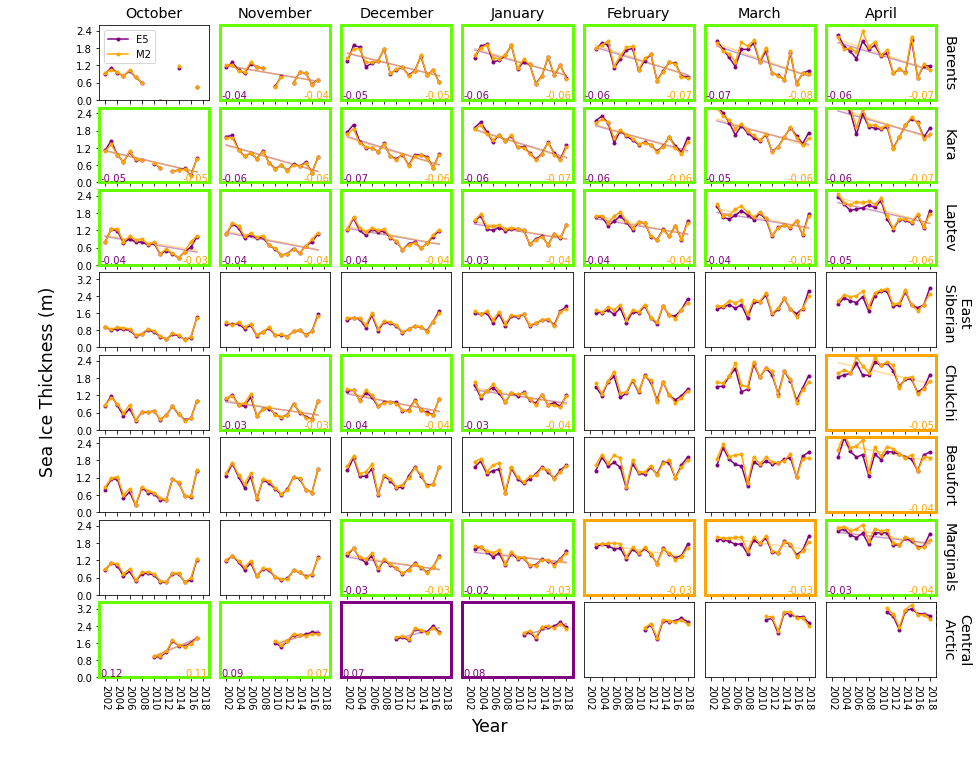

In [40]:
def timeseries(snow_product_1, snow_product_2):
    
    ice_type = 'all'
    col1 = 'purple'; col2 = 'orange'
    
    significance_increase = []
    
    trends_dict = defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))
    
    print(ice_type)

    region_annotations = {"Laptev":0.25,
                          "Kara":0.35,
                          "East Siberian":0.05,
                          "Beaufort":0.2,
                          "Central Arctic":0.05,
                          "Chukchi":0.25,
                          "Barents":0}

    ylims = {"Laptev":0.25,
              "Kara":0.35,
              "East Siberian":0.05,
              "Beaufort":0.2,
              "Central Arctic":0.05,
              "Chukchi":0.25,
              "Barents":0}

    fig = plt.figure(figsize=(15,12))
    
    for subplot_counter, (region, month) in enumerate(itertools.product(region_list,rea(month_list)),1):

        ax = plt.subplot(len(region_list),len(month_list),subplot_counter)

        SM_subset = beta[(beta['month'] == month ) & (beta['region'] == region)]
        

        SM1 = list(SM_subset[f'{ice_type} {snow_product_1} thickness'])
        SM2 = list(SM_subset[f'{ice_type} {snow_product_2} thickness'])

        yearlist = list(SM_subset['year'])

        # Calculate statistics
        SM1_stats = nanregress(yearlist,SM1)
        SM1_mean = np.nanmean(SM1)

        SM2_stats = nanregress(yearlist,SM2)
        SM2_mean = np.nanmean(SM2)
        
        if (SM1_stats[3] < 0.05) and (SM2_stats[3] < 0.05):

            # Shade if SM & W99 -> Green Solid Outline

            for spine in ax.spines.values():
                spine.set_edgecolor('#66ff00')
                spine.set_linewidth('3')
                
            ax.plot(yearlist, np.array(yearlist)*SM1_stats[0] + SM1_stats[1], color=col1, alpha=0.4)
            ax.plot(yearlist, np.array(yearlist)*SM2_stats[0] + SM2_stats[1], color=col2, alpha=0.4)
   
            ax.annotate(np.round(SM1_stats[0], decimals = 2), xy = (0.01,0.02),
                        xycoords = 'axes fraction',color=col1)
            ax.annotate(np.round(SM2_stats[0], decimals = 2), xy = (0.99,0.02),
                        xycoords = 'axes fraction',color=col2, ha='right')
        
            
            print(f'Region: {region}, Month: {month}, SM: {np.round(SM1_stats[0], decimals = 3)}, mW: {np.round(SM2_stats[0], decimals = 3)}')
            



        elif (SM1_stats[3] < 0.05):
            
            ax.plot(yearlist, np.array(yearlist)*SM1_stats[0] + SM1_stats[1], color=col1, alpha=0.4)

            # If only SM significant -> Crimson Solid outline
            
            ax.annotate(np.round(SM1_stats[0], decimals = 2), xy = (0.01,0.02),
                        xycoords = 'axes fraction',color=col1)


            for spine in ax.spines.values():
                spine.set_edgecolor(col1)
                spine.set_linewidth('3')

        elif (SM2_stats[3] < 0.05):
            
            ax.plot(yearlist, np.array(yearlist)*SM2_stats[0] + SM2_stats[1], color=col2, alpha=0.4)
            ax.annotate(np.round(SM2_stats[0], decimals = 2), xy = (0.99,0.02),
                        xycoords = 'axes fraction',color=col2, ha='right')


            # If only W99 significant -> Darkblue Solid outline

            for spine in ax.spines.values():
                spine.set_edgecolor(col2)
                spine.set_linewidth('3')

        ax.plot(yearlist,SM1,
                      marker='.',label=snow_product_1,color=col1)

        ax.plot(yearlist,SM2,
                      marker='.',label=snow_product_2,color=col2)





        # Set appropriate y axis limits

        if region in ["Central Arctic",  "East Siberian"]:
            ax.set_ylim(0,3.5)
        else:
            ax.set_ylim(0,2.6)


        # Make month name annotations

        if subplot_counter <= len(month_list):

            ax.annotate(month_name_list_full[subplot_counter-1],
                              xy = (0.5,1.1),xycoords='axes fraction',
                              fontsize="x-large",ha='center')


        # Make region name annotations

        if subplot_counter% 7 == 0:
            
            if region == 'Central Arctic':
                region_name = 'Central\n Arctic'
            elif region == 'East Siberian':
                region_name = '    East\n Siberian'
            else:
                region_name = region
            
            ax.annotate(region_name,xy = (1.05,0.5),
                              xycoords='axes fraction',
                              fontsize='x-large',
                              va='center',
                              ha='left',
                              rotation=270)

        # Make y ticks depending on ylims

        if region in ["Central Arctic",  "East Siberian"]:
            yticks = np.linspace(0,3.2,5)
            yticks = np.around(yticks,decimals=2)
        else:
            yticks = np.linspace(0,2.4,5)
            yticks = np.around(yticks,decimals=2)

        if subplot_counter % 7 == 1:

            ax.set_yticks(ticks=yticks)
            ax.set_yticklabels(yticks)
        else:
            ax.set_yticks(ticks=[])

        # Make x ticks
        
        xticks = range(2002,2019,2)
        ax.set_xlim(2001,2019)

        
        if subplot_counter < len(month_list)*(len(region_list)-1):
            ax.set_xticks(ticks=xticks)
            ax.set_xticklabels([])
        else:
            ax.set_xticks(xticks)
            ax.tick_params('x',rotation = 270)
            
        # Annotate trends
         

        # Make legend

        if subplot_counter == 1:
            plt.legend(fontsize='medium',loc='upper left')


    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.annotate("Sea Ice Thickness (m)",
                 xy = (0.04,0.5),
                 xycoords="figure fraction",
                 rotation=90,
                 fontsize="xx-large",
                 va='center')

    plt.annotate("Year",
                 xy = (0.5,0.04),
                 xycoords="figure fraction",
                 fontsize="xx-large",
                 ha='center')
    
    
    dir_to_save = f'/home/robbie/Dropbox/Apps/Overleaf/SnowModel-LG_Paper/Sup_Figs'
    fig.savefig(f"{dir_to_save}/reanalysis_trends_comparison.png",
                dpi=450, bbox_inches='tight')

    
    plt.show()
    
    
timeseries('E5','M2')

/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


all
Region: Barents, Month: 11, SM: -0.014, mW: -0.015 Frac: -66.839
Region: Barents, Month: 12, SM: -0.021, mW: -0.022 Frac: -46.099
Region: Barents, Month: 01, SM: -0.026, mW: -0.029 Frac: -35.043
Region: Barents, Month: 02, SM: -0.029, mW: -0.033 Frac: -30.127
Region: Barents, Month: 03, SM: -0.026, mW: -0.03 Frac: -33.777
Region: Kara, Month: 10, SM: -0.012, mW: -0.012 Frac: -85.885
Region: Kara, Month: 11, SM: -0.021, mW: -0.019 Frac: -52.983
Region: Kara, Month: 12, SM: -0.03, mW: -0.028 Frac: -36.349
Region: Kara, Month: 01, SM: -0.033, mW: -0.034 Frac: -29.19
Region: Kara, Month: 02, SM: -0.027, mW: -0.033 Frac: -30.704
Region: Laptev, Month: 11, SM: -0.015, mW: -0.018 Frac: -56.295
Region: Laptev, Month: 12, SM: -0.017, mW: -0.021 Frac: -47.325
Region: Laptev, Month: 01, SM: -0.019, mW: -0.026 Frac: -39.026
Region: Chukchi, Month: 12, SM: -0.016, mW: -0.02 Frac: -50.367
Region: Marginals, Month: 12, SM: -0.013, mW: -0.018 Frac: -55.498
Region: Marginals, Month: 01, SM: -0.014,

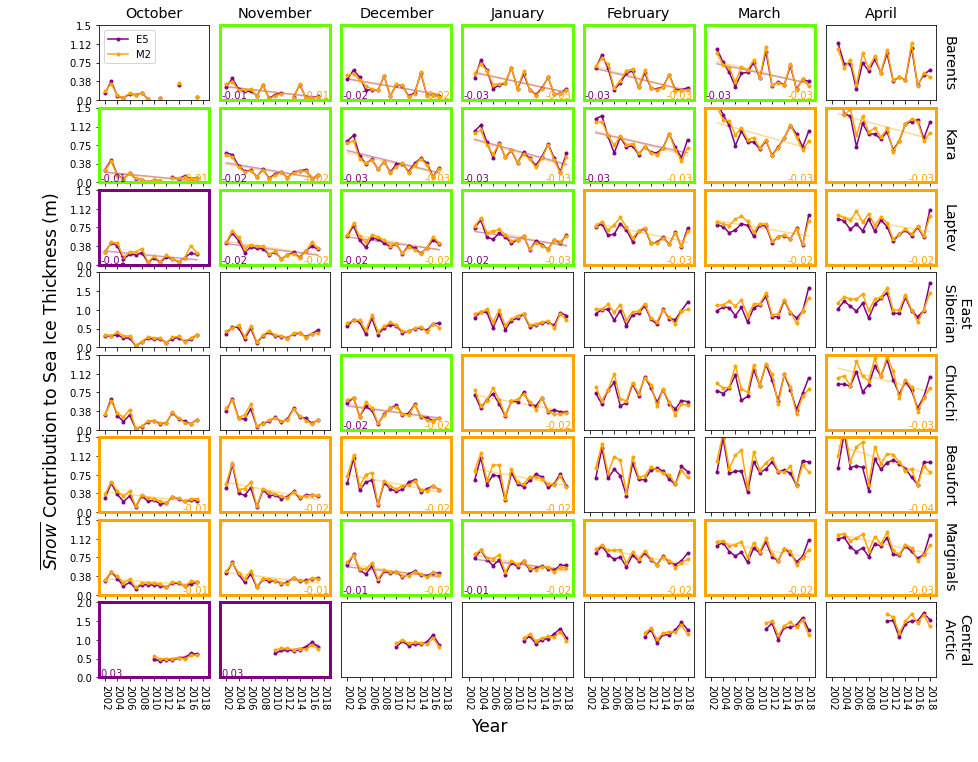

In [46]:
def timeseries(snow_product_1, snow_product_2):
    
    ice_type = 'all'
    col1 = 'purple'; col2 = 'orange'
    
    significance_increase = []
    
    trends_dict = defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))
    
    print(ice_type)

    region_annotations = {"Laptev":0.25,
                          "Kara":0.35,
                          "East Siberian":0.05,
                          "Beaufort":0.2,
                          "Central Arctic":0.05,
                          "Chukchi":0.25,
                          "Barents":0}

    ylims = {"Laptev":0.25,
              "Kara":0.35,
              "East Siberian":0.05,
              "Beaufort":0.2,
              "Central Arctic":0.05,
              "Chukchi":0.25,
              "Barents":0}

    fig = plt.figure(figsize=(15,12))
    
    for subplot_counter, (region, month) in enumerate(itertools.product(region_list,rea(month_list)),1):

        ax = plt.subplot(len(region_list),len(month_list),subplot_counter)

        SM_subset = beta[(beta['month'] == month ) & (beta['region'] == region)]
        

        SM1 = list(SM_subset[f'{ice_type} {snow_product_1} contribution'])
        SM2 = list(SM_subset[f'{ice_type} {snow_product_2} contribution'])

        yearlist = list(SM_subset['year'])

        # Calculate statistics
        SM1_stats = nanregress(yearlist,SM1)
        SM1_mean = np.nanmean(SM1)

        SM2_stats = nanregress(yearlist,SM2)
        SM2_mean = np.nanmean(SM2)
        
        if (SM1_stats[3] < 0.05) and (SM2_stats[3] < 0.05):

            # Shade if SM & W99 -> Green Solid Outline

            for spine in ax.spines.values():
                spine.set_edgecolor('#66ff00')
                spine.set_linewidth('3')
                
            ax.plot(yearlist, np.array(yearlist)*SM1_stats[0] + SM1_stats[1], color=col1, alpha=0.4)
            ax.plot(yearlist, np.array(yearlist)*SM2_stats[0] + SM2_stats[1], color=col2, alpha=0.4)
   
            ax.annotate(np.round(SM1_stats[0], decimals = 2), xy = (0.01,0.02),
                        xycoords = 'axes fraction',color=col1)
            ax.annotate(np.round(SM2_stats[0], decimals = 2), xy = (0.99,0.02),
                        xycoords = 'axes fraction',color=col2, ha='right')
        
            
            print(f'Region: {region}, Month: {month}, SM: {np.round(SM1_stats[0], decimals = 3)}, mW: {np.round(SM2_stats[0], decimals = 3)} Frac: {np.round((SM1_stats[0]/SM2_stats[0])/SM1_stats[0], decimals = 3)}')
            



        elif (SM1_stats[3] < 0.05):
            
            ax.plot(yearlist, np.array(yearlist)*SM1_stats[0] + SM1_stats[1], color=col1, alpha=0.4)

            # If only SM significant -> Crimson Solid outline
            
            ax.annotate(np.round(SM1_stats[0], decimals = 2), xy = (0.01,0.02),
                        xycoords = 'axes fraction',color=col1)


            for spine in ax.spines.values():
                spine.set_edgecolor(col1)
                spine.set_linewidth('3')

        elif (SM2_stats[3] < 0.05):
            
            ax.plot(yearlist, np.array(yearlist)*SM2_stats[0] + SM2_stats[1], color=col2, alpha=0.4)
            ax.annotate(np.round(SM2_stats[0], decimals = 2), xy = (0.99,0.02),
                        xycoords = 'axes fraction',color=col2, ha='right')


            # If only W99 significant -> Darkblue Solid outline

            for spine in ax.spines.values():
                spine.set_edgecolor(col2)
                spine.set_linewidth('3')

        ax.plot(yearlist,SM1,
                      marker='.',label=snow_product_1,color=col1)

        ax.plot(yearlist,SM2,
                      marker='.',label=snow_product_2,color=col2)





        # Set appropriate y axis limits




        # Make month name annotations

        if subplot_counter <= len(month_list):

            ax.annotate(month_name_list_full[subplot_counter-1],
                              xy = (0.5,1.1),xycoords='axes fraction',
                              fontsize="x-large",ha='center')


        # Make region name annotations

        if subplot_counter% 7 == 0:
            
            if region == 'Central Arctic':
                region_name = 'Central\n Arctic'
            elif region == 'East Siberian':
                region_name = '    East\n Siberian'
            else:
                region_name = region
            
            ax.annotate(region_name,xy = (1.05,0.5),
                              xycoords='axes fraction',
                              fontsize='x-large',
                              va='center',
                              ha='left',
                              rotation=270)

#         Make y ticks depending on ylims


        
        if region in ['Central Arctic', 'East Siberian']:
            
            ax.set_ylim(0,2)
            yticks = np.linspace(0,2,5)
        
        else:
            
            yticks = np.linspace(0,1.5,5)
            ax.set_ylim(0,1.5)

        
        yticks = np.around(yticks,decimals=2)

        if subplot_counter % 7 == 1:

            ax.set_yticks(ticks=yticks)
            ax.set_yticklabels(yticks)
        else:
            ax.set_yticks(ticks=[])

        # Make x ticks
        
        xticks = range(2002,2019,2)
        ax.set_xlim(2001,2019)

        
        if subplot_counter < len(month_list)*(len(region_list)-1):
            ax.set_xticks(ticks=xticks)
            ax.set_xticklabels([])
        else:
            ax.set_xticks(xticks)
            ax.tick_params('x',rotation = 270)
            
        # Annotate trends
         

        # Make legend

        if subplot_counter == 1:
            plt.legend(fontsize='medium',loc='upper left')


    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.annotate(r"$\overline{Snow}$ Contribution to Sea Ice Thickness (m)",
                 xy = (0.04,0.5),
                 xycoords="figure fraction",
                 rotation=90,
                 fontsize="xx-large",
                 va='center')

    plt.annotate("Year",
                 xy = (0.5,0.04),
                 xycoords="figure fraction",
                 fontsize="xx-large",
                 ha='center')
    
    
    dir_to_save = f'/home/robbie/Dropbox/Apps/Overleaf/SnowModel-LG_Paper/Sup_Figs'
    fig.savefig(f"{dir_to_save}/reanalysis_trends_comparison_snow.png",
                dpi=450, bbox_inches='tight')

    
    plt.show()
    
    
timeseries('E5','M2')

/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Barents10_-0.0
Barents11_-0.01
Barents12_-0.02
Barents01_-0.03
Barents02_-0.03
Barents03_-0.03
Barents04_-0.02
Kara10_-0.01
Kara11_-0.02
Kara12_-0.03
Kara01_-0.03
Kara02_-0.03
Kara03_-0.03
Kara04_-0.03
Laptev10_-0.01
Laptev11_-0.02
Laptev12_-0.02
Laptev01_-0.02
Laptev02_-0.02
Laptev03_-0.01
Laptev04_-0.01
East Siberian10_-0.0
East Siberian11_-0.01
East Siberian12_-0.01
East Siberian01_-0.01
East Siberian02_-0.01
East Siberian03_-0.0
East Siberian04_-0.0
Chukchi10_-0.01
Chukchi11_-0.01
Chukchi12_-0.02
Chukchi01_-0.02
Chukchi02_-0.02
Chukchi03_-0.01
Chukchi04_-0.02
Beaufort10_-0.01
Beaufort11_-0.02
Beaufort12_-0.02
Beaufort01_-0.02
Beaufort02_-0.01
Beaufort03_-0.02
Beaufort04_-0.03
Marginals10_-0.01
Marginals11_-0.01
Marginals12_-0.02
Marginals01_-0.02
Marginals02_-0.02
Marginals03_-0.01
Marginals04_-0.02
Central Arctic10_0.02
Central Arctic11_0.02
Central Arctic12_0.01
Central Arctic01_0.02
Central Arctic02_0.02
Central Arctic03_0.0
Central Arctic04_0.01


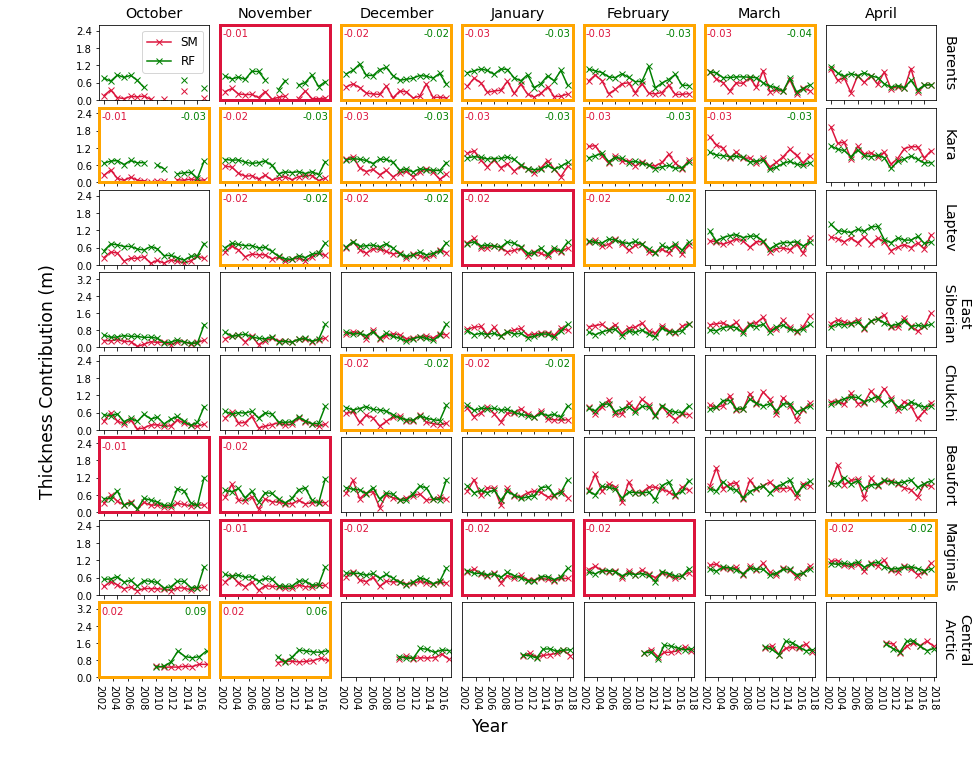

In [24]:
def timeseries(ice_type):
    
    trends_dict = {}
    
    region_annotations = {"Laptev":0.25,
                          "Kara":0.35,
                          "East Siberian":0.05,
                          "Beaufort":0.2,
                          "Central Arctic":0.05,
                          "Chukchi":0.25,
                          "Barents":0}

    ylims = {"Laptev":0.25,
              "Kara":0.35,
              "East Siberian":0.05,
              "Beaufort":0.2,
              "Central Arctic":0.05,
              "Chukchi":0.25,
              "Barents":0}

    fig = plt.figure(figsize=(15,12))
    
    subplot_counter = 1
    
    total_subplots = len(region_list) * len(month_list)

    for region in region_list:

        trends_dict[region] = {}
        
        for month in rea(month_list):

            if int(month) < 5:
                yearlist = list(range(2003,2019))
            elif int(month) > 7:
                yearlist = list(range(2002,2018))

            ax = plt.subplot(len(region_list),len(month_list),subplot_counter)
            
            W99_subset = beta[(beta['month'] == month ) & (beta['region'] == region)]
            W99 = list(W99_subset[f'{ice_type} free contribution'])
            
            SM_subset = beta[(beta['month'] == month ) & (beta['region'] == region)]
            SM = list(SM_subset[f'{ice_type} SM contribution'])
            
            yearlist = list(SM_subset['year'])
    
            
            # Deal with the trunkated Central Arctic series

            if region == 'Central Arctic':
                SM = np.array(    list(np.full(8,np.nan)) + list(SM)  )
                W99 = np.array(   list(np.full(8,np.nan)) + list(W99) )
                
                yearlist = np.array(   list(range(2002,2010)) + list(yearlist) )
                
                
                CA_flag = True

            # Calculate statistics

            SM_slope = nanregress(yearlist,SM)
            W99_slope = nanregress(yearlist,W99)
            
            print(f'{region}{month}_{np.round(SM_slope[0],decimals=2)}')

            a = SM_slope[3] < 0.05
            b = W99_slope[3] < 0.05

            if a:

                if a and b:
                    
                    trends_dict[region][month] = (SM_slope[0],W99_slope[0])
                    
                    plt.annotate(np.round(SM_slope[0], decimals = 2), xy = (0.02,0.95),
                        xycoords = 'axes fraction',color='crimson', ha='left',va='top')
                    plt.annotate(np.round(W99_slope[0], decimals = 2), xy = (0.98,0.95),
                        xycoords = 'axes fraction',color='green', ha='right',va='top')

                    # Shade if SM & W99 statistically significant slope

                    for spine in ax.spines.values():
                        spine.set_edgecolor('orange')
                        spine.set_linewidth('3')

                elif a:
                    
                    trends_dict[region][month] = (SM_slope[0],np.nan)

                    # Shade if only SM statistically significant slope
                    
                    plt.annotate(np.round(SM_slope[0], decimals = 2), xy = (0.02,0.95),
                        xycoords = 'axes fraction',color='crimson', ha='left',va='top')
                    
                    for spine in ax.spines.values():
                        spine.set_edgecolor('crimson')
                        spine.set_linewidth('3')
                        
                elif b:
                    
                    trends_dict[region][month] = (W99_slope[0],np.nan)

                    # Shade if only SM statistically significant slope
                    
                    plt.annotate(np.round(W99_slope[0], decimals = 2), xy = (0.98,0.95),
                        xycoords = 'axes fraction',color='green', ha='right',va='top')
                    
                    for spine in ax.spines.values():
                        spine.set_edgecolor('green')
                        spine.set_linewidth('3')
                    
            else:
        
                trends_dict[region][month] = (np.nan,np.nan)
                


            # Make the two line plots


            ax = plt.plot(yearlist,SM,
                          marker='x',label='SM',color='crimson')

            ax = plt.plot(yearlist,W99,
                          marker='x',label='RF',color='green')





            # Set appropriate y axis limits

            if region in ["Central Arctic",  "East Siberian"]:
                ax = plt.ylim(0,3.5)
            else:
                ax = plt.ylim(0,2.6)


            # Make month name annotations

            if subplot_counter < 8:

                ax = plt.annotate(month_name_list_full[subplot_counter-1],
                                  xy = (0.5,1.1),xycoords='axes fraction',
                                  fontsize="x-large",ha='center')

            # Make region name annotations

            if subplot_counter% 7 == 0:

                if region == 'Central Arctic':
                    region_name = 'Central\n Arctic'
                elif region == 'East Siberian':
                    region_name = '    East\n Siberian'
                else:
                    region_name = region

                ax = plt.annotate(region_name,xy = (1.05,0.5),
                                  xycoords='axes fraction',
                                  fontsize='x-large',
                                  va='center',
                                  ha='left',
                                  rotation=270)

            # Make y ticks depending on ylims

            if region in ["Central Arctic",  "East Siberian"]:
                yticks = np.linspace(0,3.2,5)
                yticks = np.around(yticks,decimals=2)
            else:
                yticks = np.linspace(0,2.4,5)
                yticks = np.around(yticks,decimals=2)

            if (subplot_counter-1) %7 == 0:

                plt.yticks(ticks=yticks,labels=yticks)
            else:
                plt.yticks(ticks=[])

            # Make x ticks

            if subplot_counter < total_subplots-7:
                plt.xticks(ticks=list(range(yearlist[0],yearlist[-1],2)),labels=[])
            else:

                plt.xticks(np.arange(yearlist[0], yearlist[-1]+1, 2),rotation = 270)

            # Make legend

            if subplot_counter == 1:
                plt.legend(fontsize='large',loc='upper right')
                
                
            subplot_counter +=1

    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.annotate("Thickness Contribution (m)",
                 xy = (0.04,0.5),
                 xycoords="figure fraction",
                 rotation=90,
                 fontsize="xx-large",
                 va='center')

    plt.annotate("Year",
                 xy = (0.5,0.04),
                 xycoords="figure fraction",
                 fontsize="xx-large",
                 ha='center')
    
    dir_to_save = f'/home/robbie/Dropbox/Apps/Overleaf/SnowModel-LG_Paper/Sup_Figs'
    fig.savefig(f"{dir_to_save}/fb_vs_sm_contributions.png",
                dpi=450, bbox_inches='tight')
    
    plt.show()
    
    
timeseries('all')